# Analysis of the gills
- Oleksiy and Flu scanned them
- Dea delineated them
- David does the analysis

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set_style('dark')
from matplotlib_scalebar.scalebar import ScaleBar
import os
import platform
import pandas
import glob
import scipy.misc
import imageio
import scipy.stats
import numpy
import skimage.filters
import skimage.morphology
import gc
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Style plots
seaborn.set_style("whitegrid")
seaborn.set_context("paper")

In [3]:
# Display and output defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
# plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['savefig.dpi'] = 300  # Save (PNG) images with a higher DPI, since Authorea cannot import PDFs...
plt.rcParams["savefig.transparent"] = True

In [4]:
# Setup scale bar
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [5]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [6]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [7]:
def whodunit(logfile):
    """
    Who did the scan?
    https://en.wikipedia.org/wiki/Whodunit"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'User Name' in line:
                user = line.split('=')[1].rstrip()
    return(user)

In [8]:
def percentage(value1, value2):
    """
    We use this over and over in the results part.
    Just a helper function to print out the percentage increase.
    """
    p = value2 / value1
    p -= 1
    p *= 100
    return(p)

In [9]:
def significance(p):
    """
    Get some 'information' on the p-values we calculate.
    See the bottom of https://git.io/vQbWV
    """
    if p < 0.0001:
        return "**** (p=%0.3g)" % p
    elif (p < 0.001):
        return "*** (p=%0.3g)" % p
    elif (p < 0.01):
        return "** (p=%0.3g)" % p
    elif (p < 0.05):
        return "* (p=%0.3g)" % p
    else:
        return "not significant (p=%0.3g)" % p

In [10]:
# Work on the fast SSD from here on!
FastSSD = True
if 'debian' in platform.dist():
    if FastSSD:
        StartDir = '/media/habi/Fast_SSD/'
    else:
        StartDir = '/media/habi/Blue Seagate/'
else:
    if FastSSD:
        StartDir = 'F:/'
    else:
        StartDir = 'G:/'
RootFolder = os.path.join(StartDir, 'Zebra-Fish_Matthias')

In [11]:
print('We are loading all the data from %s' % RootFolder)

We are loading all the data from /media/habi/Fast_SSD/Zebra-Fish_Matthias


In [12]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving the output images to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving the output images to /home/habi/P/Documents/Zebrafish-Gills/Output/7f5b1e4


In [13]:
# Display all plots identically
lines = 5
# And then do something like
# plt.subplot(lines, numpy.ceil(len(ROIFolder) / float(lines)), c + 1)

Let's get going, now that we set up everything...

Get the data from the microCT scans

In [14]:
# Get a list of all the samples we scanned
try:
    SampleNames = sorted(next(os.walk(RootFolder))[1])
except StopIteration:
    print('Please mount the fast SSD!')

In [15]:
# Remove Folder we don't want
if not FastSSD:
    SampleNames.remove('Original SEM Bilder')
    SampleNames.remove('tresholding_estimation')

In [16]:
# Save all the information into a pandas dataframe
Data = pandas.DataFrame({'Sample': SampleNames})
Data['Folder'] = [os.path.join(RootFolder, s) for s in SampleNames]
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, 'proj', '*.log')))[0] for f in Data.Folder]
Data['RecFolder'] = [os.path.join(RootFolder, f, 'rec') for f in Data.Folder]
Data['VOIFolder'] = [os.path.join(RootFolder, f, 'VOI') for f in Data.Folder]
Data['OverviewName'] = [glob.glob(os.path.join(r, '*spr.bmp'))[0] for r in Data.RecFolder]
Data['ReconstructionNames'] = [sorted(glob.glob(os.path.join(r, '*.png'))) for r in Data.RecFolder]
# Try to be a bit clever with loading the VOI slices
# They are saved as either PNG or BMP, and there's also some other stuff in the folder...
Data['VOINames'] = [sorted(glob.glob(os.path.join(r, '*rec*[0123456789].*'))) for r in Data.VOIFolder]

In [17]:
# Make an 'experiment' column, which we use for the box plots below
def whichexperiment(i):
    '''Categorize  into 'Swimmer' or 'Control' '''
    if 'immer' in i:
        return 'Swimmer'
    if 'ontrol' in i:
        return 'Control'

In [18]:
Data['Experiment'] = [whichexperiment(name) for name in Data.Folder]

In [19]:
# Color plot based on label (mrt, ctrl or bb)
def color_based_on_experiment(i):
    '''Colorize into 'Swimmer' or 'Control' '''
    if 'ontrol' in i:
        return seaborn.color_palette()[0]
    if 'immer' in i:
        return seaborn.color_palette()[1]

In [20]:
Data['Color'] = [color_based_on_experiment(name) for name in Data.Folder]

In [21]:
# Get Pixel sizes of the scans
# in micrometers
Data['PixelSize'] = [get_pixelsize(logfile) for logfile in Data.LogFile]

In [22]:
# Get Pixel sizes of the scans
# in micrometers
Data['ScanMaster'] = [whodunit(logfile) for logfile in Data.LogFile]

In [23]:
# Who did what?
for who in Data.ScanMaster.unique():
    print('%s scanned %s samples' % (who, len(Data[Data.ScanMaster == who])))

khoma scanned 6 samples
haberthu scanned 6 samples
fw13i082 scanned 8 samples


In [24]:
# Calculate the voxel volume, which we'll use later on
# Let's use microlitre as unit
Data['VoxelVolume'] = [ps ** 3 * 1e-9 for ps in Data.PixelSize]

In [25]:
# Make ourselves a 'fish colum', which we need later on for merging different data frames
# (e.g. Gill volume and morphology)
Data['Fish'] = [int(n.split('_')[0][-2:]) for n in Data.Sample]

Load the other data (XLS files from Matthias).

In [26]:
# Load the fish length data
morphologyfile = glob.glob(os.path.join('XLS*', '*morph*.xlsx'))[0]
# Load all the morphology data into its own dataframe
# With a hat tip to https://stackoverflow.com/a/49442625/323100
Morphology = pandas.read_excel(morphologyfile,
                               usecols='E:H,K:N',
                               skiprows=3,
                               nrows=27,
                               names=['Length Swimmer Before',
                                      'Weight Swimmer Before',
                                      'Length Control Before',
                                      'Weight Control Before',
                                      'Length Swimmer After',
                                      'Weight Swimmer After',
                                      'Length Control After',
                                      'Weight Control After'])
# Drop unneeded rows
Morphology.drop([10, 11, 12, 13, 14, 15, 16], inplace=True)
# Get ourselves the fish number in a column
Morphology['Fish'] = range(1, 21)
Morphology['Fish'][10:] = range(1, 11)
# Get ourselves the gender in a column
Morphology['Gender'] = 'Female'
Morphology['Gender'][10:] = 'Male'

In [27]:
# Massage the morphology data into a new dataframe for displaying it nicely
# One fish for the swimmers after training died, so we temporarily
# replace it's data with 9999 to we can still do the 'dropna' dance below
Morphology.fillna(value=9999, inplace=True)
# First, pull together so we get a proper 'Training' column
mo = pandas.concat([Morphology[['Gender',
                                'Fish',
                                'Length Control Before',
                                'Length Swimmer Before',
                                'Weight Control Before',
                                'Weight Swimmer Before']],
                    Morphology[['Gender',
                                'Fish',
                                'Length Control After',
                                'Length Swimmer After',
                                'Weight Control After',
                                'Weight Swimmer After']]])

mo['Length Control'] = pandas.concat([mo['Length Control Before'].dropna(),
                                      mo['Length Control After'].dropna()])
mo['Length Swimmer'] = pandas.concat([mo['Length Swimmer Before'].dropna(),
                                      mo['Length Swimmer After'].dropna()])
mo['Weight Control'] = pandas.concat([mo['Weight Control Before'].dropna(),
                                      mo['Weight Control After'].dropna()])
mo['Weight Swimmer'] = pandas.concat([mo['Weight Swimmer Before'].dropna(),
                                      mo['Weight Swimmer After'].dropna()])
mo['Training'] = ['Before' if o > 0 else 'After' for o in mo['Length Control Before']]
# Then, pull together so we get a proper 'Experiment' column
mo2 = pandas.concat([mo[['Gender',
                         'Fish',
                         'Training',
                         'Length Control',
                         'Weight Control']],
                     mo[['Gender',
                         'Fish',
                         'Training',
                         'Length Swimmer',
                         'Weight Swimmer']]])
mo2['Length'] = pandas.concat([mo2['Length Control'].dropna(),
                               mo2['Length Swimmer'].dropna()])
mo2['Weight'] = pandas.concat([mo2['Weight Control'].dropna(),
                               mo2['Weight Swimmer'].dropna()])
mo2['Experiment'] = ['Swimmer' if i > 0 else 'Control' for i in mo2['Length Swimmer']]
# Set that one fish back to NaN
mo2.replace(9999, numpy.nan, inplace=True)
# Set the massaged data back to the Morphology dataframe
Morphology = mo2

In [28]:
# Merge (correct) morphology data into the other data
# We need that later on for normalizing calculated values to the fish length
Data = pandas.merge(Data,
                    Morphology[(Morphology.Gender == 'Female') &
                               (Morphology.Training == 'After')])

In [29]:
# Load the respirometry data
# Since it's in a 'messy' xls sheet, we cannot do it in one go, but do it in four cells :)
respirometryfile = glob.glob(os.path.join('XLS*', '*', 'Respirometry*.xlsx'))[0]
# Based on https://stackoverflow.com/a/49442625/323100
# Load O2 at start
o2 = pandas.read_excel(respirometryfile, index_col=None, skiprows=1, usecols='H')
Data['O2 consumption start'] = pandas.concat([o2], ignore_index=True)

In [30]:
# Load O2 at start, normalized
o2_norm = pandas.read_excel(respirometryfile, index_col=None, skiprows=1, usecols='I')
# Unfortunately, Matthias saved some more stuff into this colum, so we just drop some cells
o2_norm.drop([10, 21, 22], inplace=True)
Data['O2 consumption start normalized'] = pandas.concat([o2_norm], ignore_index=True)

In [31]:
# Load O2 at the end
o2_end = pandas.read_excel(respirometryfile, index_col=None, skiprows=1, usecols='P')
Data['O2 consumption end'] = pandas.concat([o2_end], ignore_index=True)

In [32]:
# Load O2 at end, normalized
o2_norm_end = pandas.read_excel(respirometryfile, index_col=None, skiprows=1, usecols='Q')
# Unfortunately, Matthias saved some more stuff into this colum, so we just drop some cells
o2_norm_end.drop([10, 20], inplace=True)
Data['O2 consumption end normalized'] = pandas.concat([o2_norm_end], ignore_index=True)

In [33]:
# Double-check the data
# Data[['Sample',
#       'O2 consumption start', 'O2 consumption start normalized',
#       'O2 consumption end', 'O2 consumption end normalized']]

In [34]:
# Massage the respirometry data into a new dataframe for displaying it nicely
# On some respirometry data we have NaN.
# Let's fill this with 9999, so that we can merge the before/after data
Data.fillna(value=9999, inplace=True)
# Generate us a new dataframe
Respirometry = pandas.concat([Data[['Sample', 'Experiment', 'O2 consumption start normalized']],
                              Data[['Sample', 'Experiment', 'O2 consumption end normalized']]])
# Let's put NaN back
Data.replace(9999, numpy.nan, inplace=True)
# Merge, based on https://stackoverflow.com/a/10972557/323100
Respirometry['o2'] = pandas.concat([Respirometry['O2 consumption start normalized'].dropna(),
                                    Respirometry['O2 consumption end normalized'].dropna()])
# Make us an experiment state, so we can 'hue' on this later
Respirometry['Training'] = ['Before' if o > 0 else 'After' for o in Respirometry['O2 consumption start normalized']]
# Set that one value back to NaN
Respirometry.replace(9999, numpy.nan, inplace=True)

In [35]:
# Load the SEM data
semfile = glob.glob(os.path.join('XLS*', '*', '*electron*.xlsx'))[0]
# Load filament count
# We could probably do it in one go as above, but then 'squeeze' doesn't seem to discard the empty lines...
Filaments = pandas.DataFrame()
Filaments['Swimmer Count'] = pandas.read_excel(semfile, usecols='G', nrows=199, squeeze=True)
Filaments['Control Count'] = pandas.read_excel(semfile, usecols='AA', nrows=199, squeeze=True, na_values='Keine Daten')
# Load filament length
Filaments['Swimmer Length'] = pandas.read_excel(semfile, usecols='Q', nrows=199, squeeze=True)
Filaments['Control Length'] = pandas.read_excel(semfile, usecols='AK', nrows=199, squeeze=True, na_values='Keine Daten')
# Scale from Fiji measurement units to um
Filaments['Swimmer Length'] *= 1 / 0.6 * 100
Filaments['Control Length'] *= 1 / 0.6 * 100

In [36]:
# Load the speed assessment data
speedfile = glob.glob(os.path.join('XLS*', '*speed*.xlsx'))[0]
# Load two empty colums (G, H) for dummy data ('Control 3wk' and 'Control rpm 3wk')
Speed = pandas.read_excel(speedfile,
                          usecols='B,C,E,F,G,H,O,P,R,S,U,V',
                          skiprows=3,
                          nrows=29,
                          names=['Swimmer Before',
                                 'Swimmer rpm Before',
                                 'Control Before',
                                 'Control rpm Before',
                                 'Control 3wk',
                                 'Control rpm 3wk',
                                 'Swimmer 3wk',
                                 'Swimmer rpm 3wk',
                                 'Swimmer After',
                                 'Swimmer rpm After',
                                 'Control After',
                                 'Control rpm After'])
# Drop unneeded colums and reset the numbering (index)
Speed.drop([10, 11, 12, 13, 14, 15, 16, 17, 18], inplace=True)
Speed.reset_index(inplace=True, drop=True)
# Convert the weird Excel time to something we can actually use...
# Pandas parses the M:S Matthias entered as H:M:00
# It would probably easy to do this via a parser, but just converting it with a Timedelta is quicker
# (Which just means I gave up after putting keywords into a search engine for two hours
Speed['Swimmer Before'] = [pandas.Timedelta(minutes=time.hour,
                                            seconds=time.minute) for time in Speed['Swimmer Before']]
Speed['Control Before'] = [pandas.Timedelta(minutes=time.hour,
                                            seconds=time.minute) for time in Speed['Control Before']]
# Since we have NaN (as float) in the column (data for fish 10 is missing)
# we jump through this super-complicated hoop to covert the time to timedelta so that we have NaT
# with a tip to the hat to https://stackoverflow.com/a/25142407/323100
Speed['Swimmer 3wk'] = [pandas.Timedelta(minutes=time.hour, seconds=time.minute)
                        if not pandas.isnull(time) else pandas.to_datetime('13000101',
                                                                           format='%Y%m%d',
                                                                           errors='coerce')
                        for time in Speed['Swimmer 3wk']]
Speed['Swimmer After'] = [pandas.Timedelta(minutes=time.hour, seconds=time.minute)
                          if not pandas.isnull(time) else pandas.to_datetime('13000101',
                                                                             format='%Y%m%d',
                                                                             errors='coerce')
                          for time in Speed['Swimmer After']]
Speed['Control After'] = [pandas.Timedelta(minutes=time.hour,
                                           seconds=time.minute) for time in Speed['Control After']]
# Get ourselves the fish number in a column
Speed['Fish'] = range(1, 21)
Speed['Fish'][10:] = range(1, 11)
# Get ourselves the gender in a column
Speed['Gender'] = 'Female'
Speed['Gender'][10:] = 'Male'
# Fill the dummy colums with dummy values
Speed['Control 3wk'] = pandas.Timedelta(minutes=99)
Speed['Control rpm 3wk'] = 13

In [37]:
# Massage the speed data into a new dataframe for displaying it nicely
# One fish for the swimmers after training died missing,
# replace it's data with 9999 so we can still do the 'dropna' dance below
Speed.fillna(value=9999, inplace=True)
# First, pull together so we get a proper 'Training' column
sp = pandas.concat([Speed[['Gender',
                           'Fish',
                           'Control Before',
                           'Swimmer Before']],
                    Speed[['Gender',
                           'Fish',
                           'Control 3wk',
                           'Swimmer 3wk']],                    
                    Speed[['Gender',
                           'Fish',
                           'Control After',
                           'Swimmer After']]])
sp['Control'] = pandas.concat([sp['Control Before'].dropna(),
                               sp['Control 3wk'].dropna(),
                               sp['Control After'].dropna()])
sp['Swimmer'] = pandas.concat([sp['Swimmer Before'].dropna(),
                               sp['Swimmer 3wk'].dropna(),
                               sp['Swimmer After'].dropna()])
# Make us a 'Training' column
sp['Training'] = 'Before'
# https://stackoverflow.com/a/12307162/323100
sp.loc[sp['Swimmer 3wk'] > pandas.Timedelta(seconds=1), 'Training'] = '3 wk'
sp.loc[sp['Swimmer After'] > pandas.Timedelta(seconds=1), 'Training'] = '5 wk'
# Then, pull together so we get a proper 'Experiment' column
sp2 = pandas.concat([sp[['Gender',
                         'Fish',
                         'Training',
                         'Control']],
                     sp[['Gender',
                         'Fish',
                         'Training',
                         'Swimmer']]])
sp2['Time'] = pandas.concat([sp2['Control'].dropna(),
                             sp2['Swimmer'].dropna()])
sp2['Experiment'] = ['Swimmer' if i > pandas.Timedelta(seconds=0) else 'Control' for i in sp2['Swimmer']]
# Set the special values back to NaT/NaN
sp2.replace(pandas.Timedelta(seconds=9999.), numpy.nan, inplace=True)
sp2.replace(pandas.Timedelta(seconds=5940.), numpy.nan, inplace=True)
# Set the massaged data back to the Morphology dataframe
Speed = sp2
# Make us a 'total seconds' column for plotting later on
Speed['Seconds'] = [t.total_seconds() for t in Speed.Time]

----
Now that we have read all the data we need, we actually read the images.
And do some image processing to get to the gill volume.

In [38]:
# Load Overview images
Overviews = [imageio.imread(o) for o in Data.OverviewName]

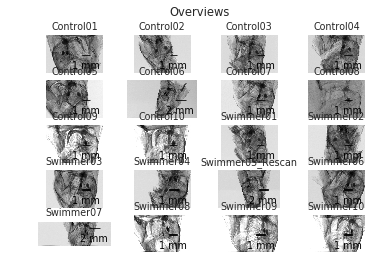

In [39]:
# Display overviews (shadow projections)
for c, o in enumerate(Overviews):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(o)
    plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um', color='black'))
    plt.axis('off')
    plt.title('%s' % Data.Sample[c])
plt.suptitle('Overviews')
plt.savefig(os.path.join(OutPutDir, 'Overviews.png'), bbox_inches = 'tight')
plt.show()

In [40]:
# Convert all VOI slices of each fish into single NumPy arrays and save them to disk
# But only do this if we didn't do it already :)
# Partially based on http://stackoverflow.com/a/39195332/323100
# Since we reload/memorymap the stack below, we overwrite the variable with NaN and clear the memory
Data['OutputNameVOI'] = [os.path.join(f, sample + '_VOI.npy') for f, sample in zip(Data.Folder, Data.Sample)]
# Don't save into the dataframe, or else we won't be able to make it :)
VOIImages = [numpy.nan for file in Data.OutputNameVOI]
for c, voi in enumerate(Data.OutputNameVOI):
    # Only do this if we didn't do it already...
    if os.path.exists(voi):
        print('%2s/%s: %16s: Already saved to %s' % (c + 1, len(Data.Sample), Data.Sample[c], voi[len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Reading %4s VOI images' % (c + 1, len(Data.Sample), Data.Sample[c], len(Data.VOINames[c])))
        # Actually load the images now
        VOIImages[c] = numpy.array([scipy.misc.imread(i, flatten=True) for i in Data.VOINames[c]])
        # Save the images to NumPy binary files, disallowing pickle for portability
        print('%23s: Saving to %s' % (Data.Sample[c], voi))
        numpy.save(voi, VOIImages[c], allow_pickle=False)
        # Clear memory
        VOIImages[c] = numpy.nan
        gc.collect()

 1/20:        Control01: Already saved to /Control01/Control01_VOI.npy
 2/20:        Control02: Already saved to /Control02/Control02_VOI.npy
 3/20:        Control03: Already saved to /Control03/Control03_VOI.npy
 4/20:        Control04: Already saved to /Control04/Control04_VOI.npy
 5/20:        Control05: Already saved to /Control05/Control05_VOI.npy
 6/20:        Control06: Already saved to /Control06/Control06_VOI.npy
 7/20:        Control07: Already saved to /Control07/Control07_VOI.npy
 8/20:        Control08: Already saved to /Control08/Control08_VOI.npy
 9/20:        Control09: Already saved to /Control09/Control09_VOI.npy
10/20:        Control10: Already saved to /Control10/Control10_VOI.npy
11/20:        Swimmer01: Already saved to /Swimmer01/Swimmer01_VOI.npy
12/20:        Swimmer02: Already saved to /Swimmer02/Swimmer02_VOI.npy
13/20:        Swimmer03: Already saved to /Swimmer03/Swimmer03_VOI.npy
14/20:        Swimmer04: Already saved to /Swimmer04/Swimmer04_VOI.npy
15/20:

In [41]:
# Free the memory of the images we loaded.
# We 'memory-map' them again below
%xdel VOIImages

In [42]:
# Load (or memory-map) all the files.
# This is loading the images like a virtual stack in ImageJ
VOIImages = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]

In [43]:
# Get ourselves the middle slice to show
Data['MiddleSliceName'] = [n[len(n) // 2] for n in Data.VOINames]
Data['MiddleSlice'] = [i[len(i) // 2] for i in VOIImages]

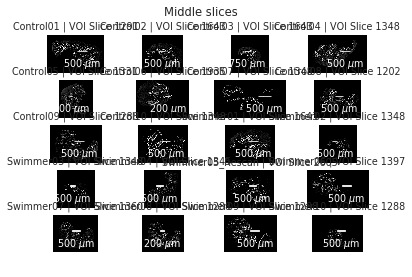

In [44]:
# Display the middle slice of the VOI
for c, m in enumerate(Data.MiddleSlice):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(m, vmax=0.618 * numpy.max(m))
    plt.title('%s | VOI Slice %s' % (Data.Sample[c], os.path.basename(Data.MiddleSliceName[c])[-8:-4]))
    plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
    plt.axis('off')
plt.suptitle('Middle slices')
plt.savefig(os.path.join(OutPutDir, 'MiddleSlices.png'), bbox_inches = 'tight')
plt.show()

In [45]:
# Get ourselves some information on the VOI size
Data['NumberOfVOISlices'] = [len(v) for v in Data.VOINames]
Data['VOIShape'] = [voi.shape for voi in VOIImages]
Data['VOIVolume'] = [shape[0] * shape[1] * shape[2] for shape in Data.VOIShape]

In [46]:
# Check of VOI size and number of files is consistent.
# If no output, everything is correct.
for i in range(20):
    if len(Data.VOINames[i]) != len(VOIImages[i]):
        print(Data.Sample[i])
        print(len(Data.VOINames[i]))
        print(Data.VOIShape[i][0])
        print(len(VOIImages[i]))
        print(80 * '-')

In [47]:
# Average volume/size
print('The average VOI site is a cube '
      'with a side length of %s pixels' % int(round(Data.VOIVolume.mean() ** (1 / 3.))))

The average VOI site is a cube with a side length of 1938 pixels


In [48]:
# For bragging reasons in the manuscript
# 'sort_values' does an ascending sort by default, so let's look at the biggest (last/'tail(1)'') item
print('The largest VOI is')
print(Data[['Sample', 'VOIVolume', 'NumberOfVOISlices', 'VOIShape']].sort_values('VOIVolume').tail(1))
print(80 * '-')
# 'sort_values' does an ascending sort by default, so let's look at the smallest (first/'head(1)') item
print('The smallest VOI is')
print(Data[['Sample', 'VOIVolume', 'NumberOfVOISlices', 'VOIShape']].sort_values('VOIVolume').head(1))

The largest VOI is
      Sample    VOIVolume  NumberOfVOISlices            VOIShape
2  Control03  19506703712               3062  (3062, 2524, 2524)
--------------------------------------------------------------------------------
The smallest VOI is
      Sample   VOIVolume  NumberOfVOISlices           VOIShape
6  Control07  3765644288               2452  (2452, 896, 1714)


In [49]:
# Use a manageable amount of equally spaced slices for thresholding and MIP-ing
# This was done in the evaluation stage of the notebook
# NumberOfImagesToShow = 6
# NumberOfImagesToShow = 16
# NumberOfImagesToShow = 111
# NumberOfImagesToShow = 222
# NumberOfImagesToShow = 350
# NumberOfImagesToShow = 1111
# For the finalized version, we just use all the slices we have
NumberOfImagesToShow = Data.NumberOfVOISlices.max()

In [50]:
# Generate the subset information
Data['PrintEverySlice'] = [int(round(len(r) / NumberOfImagesToShow)) for r in Data.VOINames]
Data['SubsetNames'] = [rn[::sw] for rn, sw in zip(Data.VOINames, Data.PrintEverySlice)]
for c, i in enumerate(Data.Sample):
    print('For %s we are working with a subset of %s (%0.1f %% of totally %s) equally '
          'spaced slices' % (i,
                             len(Data.SubsetNames[c]),
                             len(Data.SubsetNames[c]) / len(Data.VOINames[c]) * 100,
                             len(Data.VOINames[c])))

For Control01 we are working with a subset of 2338 (100.0 % of totally 2338) equally spaced slices
For Control02 we are working with a subset of 3062 (100.0 % of totally 3062) equally spaced slices
For Control03 we are working with a subset of 3062 (100.0 % of totally 3062) equally spaced slices
For Control04 we are working with a subset of 2452 (100.0 % of totally 2452) equally spaced slices
For Control05 we are working with a subset of 2642 (100.0 % of totally 2642) equally spaced slices
For Control06 we are working with a subset of 3389 (100.0 % of totally 3389) equally spaced slices
For Control07 we are working with a subset of 2452 (100.0 % of totally 2452) equally spaced slices
For Control08 we are working with a subset of 2400 (100.0 % of totally 2400) equally spaced slices
For Control09 we are working with a subset of 2572 (100.0 % of totally 2572) equally spaced slices
For Control10 we are working with a subset of 2452 (100.0 % of totally 2452) equally spaced slices
For Swimme

In [51]:
# Put len of 'UseThis' into dataframe
Data['NumberOfAnalyzedVOISlices'] = [len((a)) for a in Data.SubsetNames]

In [52]:
# Calculate the thresholds on each and every image
Data['OutputNameThreshold'] = [os.path.join(f,
                                            sample + '_thresholds_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                   len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
Data['Threshold'] = [[numpy.nan] for s in Data.Sample]
for c, thresholdname in enumerate(Data.OutputNameThreshold):
    if os.path.exists(thresholdname):
        print('%2s/%s: %16s: Grab values from %s' % (c + 1,
                                                     len(Data),
                                                     Data.Sample[c],
                                                     thresholdname[len(RootFolder):]))
        Data['Threshold'][c] = numpy.load(thresholdname)
    else:
        print('%2s/%s: %16s: Calculating thresholds for %s of %4s files' % (c + 1,
                                                                            len(Data), Data.Sample[c],
                                                                            len(Data.VOINames[c][::Data.PrintEverySlice[c]]),
                                                                            len(Data.VOINames[c])))
        Data['Threshold'][c] = [numpy.nan] * len(Data.VOINames[c][::Data.PrintEverySlice[c]])
        for d, image in enumerate(VOIImages[c][::Data.PrintEverySlice[c]]):
            try:
                # Calculate and save threshold (of only the image, e.g. img[img>0])
                Data['Threshold'][c][d] = skimage.filters.threshold_otsu(image[image > 0])
            except (ValueError):
                # Save NaN if we can't calculate a threshold
                Data['Threshold'][c][d] = numpy.nan
        print('%23s: Saving thresholds to %s' % (Data.Sample[c], thresholdname[len(RootFolder):]))
        numpy.save(thresholdname, Data.Threshold[c], allow_pickle=False)
        Data.Threshold[c] = numpy.nan
        gc.collect()

 1/20:        Control01: Grab values from /Control01/Control01_thresholds_from_2338_of_2338_slices.npy
 2/20:        Control02: Grab values from /Control02/Control02_thresholds_from_3062_of_3062_slices.npy
 3/20:        Control03: Grab values from /Control03/Control03_thresholds_from_3062_of_3062_slices.npy
 4/20:        Control04: Grab values from /Control04/Control04_thresholds_from_2452_of_2452_slices.npy
 5/20:        Control05: Grab values from /Control05/Control05_thresholds_from_2642_of_2642_slices.npy
 6/20:        Control06: Grab values from /Control06/Control06_thresholds_from_3389_of_3389_slices.npy
 7/20:        Control07: Grab values from /Control07/Control07_thresholds_from_2452_of_2452_slices.npy
 8/20:        Control08: Grab values from /Control08/Control08_thresholds_from_2400_of_2400_slices.npy
 9/20:        Control09: Grab values from /Control09/Control09_thresholds_from_2572_of_2572_slices.npy
10/20:        Control10: Grab values from /Control10/Control10_thresholds

In [53]:
# Load (or memory-map) all the files.
# This is loading the images like a virtual stack in ImageJ
Data['Threshold'] = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameThreshold]

In [54]:
# Let's calculate the max, mean and median threshold for each sample
Data['ThresholdMax'] = [numpy.nanmax(t) for t in Data.Threshold]
# Discard the first and last $discard slices for the averaging 
discard = 150
Data['ThresholdAverage'] = [numpy.nanmean(t[discard:-discard]) for t in Data.Threshold]
Data['ThresholdMedian'] = [numpy.nanmedian(t[discard:-discard]) for t in Data.Threshold]

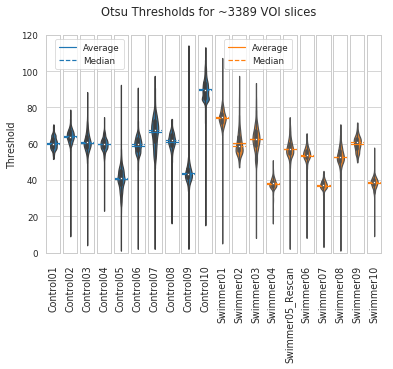

In [55]:
# Plot the Thresholds
for c, i in enumerate(Data.Threshold):
    plt.subplot(1, len(Data), c + 1)
    seaborn.violinplot(i[discard:-discard], orient='v', color=Data.Color[c], cut=0, width=0.5)
    plt.axhline(Data.ThresholdAverage[c], label='Average', color=Data.Color[c])
    plt.axhline(Data.ThresholdMedian[c], label='Median', color=Data.Color[c], ls='dashed')
    plt.ylim([0, Data.ThresholdMax.max() * 1.05])
    if c:
        plt.gca().axes.yaxis.set_ticklabels([])
    else:
        plt.ylabel('Threshold')
    if '05' in Data.Sample[c]:
        plt.legend()
    plt.xlabel(Data.Sample[c], rotation=90)
plt.suptitle('Otsu Thresholds for ~%s VOI slices' % NumberOfImagesToShow)
plt.savefig(os.path.join(OutPutDir, 'Thresholds_from%04dslices.png' % NumberOfImagesToShow), bbox_inches = 'tight')
plt.show()

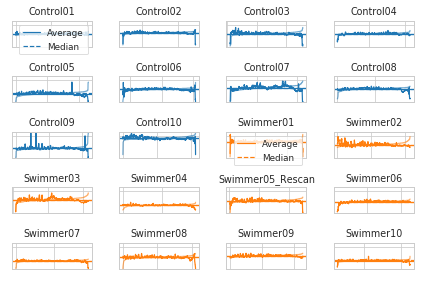

In [56]:
# Plot the Thresholds
for c, i in enumerate(Data.Threshold):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.plot(i[discard:-discard], color=Data.Color[c])
    plt.plot(sorted(i[discard:-discard]), color=Data.Color[c], alpha=0.618)
    plt.axhline(Data.ThresholdAverage[c], label='Average', color=Data.Color[c])
    plt.axhline(Data.ThresholdMedian[c], label='Median', color=Data.Color[c], ls='dashed')
    plt.ylim([0, Data.ThresholdMax.max() * 1.05])
    plt.title(Data.Sample[c])
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    if '01' in Data.Sample[c]:
        plt.legend()
# plt.suptitle('Otsu Thresholds for ~%s VOI slices' % NumberOfImagesToShow)
plt.tight_layout()
plt.savefig(os.path.join(OutPutDir, 'Thresholds-plot_from%04dslices.png' % NumberOfImagesToShow), bbox_inches = 'tight')
plt.show()

In [57]:
# Read a subset of images
Data['OutputNameVOISubset'] = [os.path.join(f,
                                            sample + '_VOI_subset_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                   len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
# Don't save into the dataframe, or else we won't be able to make it to the end :)
VOISubset = [numpy.nan for file in Data.OutputNameVOISubset]
for c, subset in enumerate(Data.OutputNameVOISubset):
    if len(Data.VOINames[c]) != len(Data.VOINames[c][::Data.PrintEverySlice[c]]):
        # We are using a subset
        # Only do this if we didn't do it already...
        if os.path.exists(subset):
            print('%2s/%s: %16s: Already saved to %s' % (c + 1,
                                                         len(Data.Sample),
                                                         Data.Sample[c],
                                                         subset[len(RootFolder):]))
        else:
            print('%2s/%s: %16s: Subsetting %s of %s VOI images' % (c + 1,
                                                                    len(Data.Sample),
                                                                    Data.Sample[c],
                                                                    len(Data.SubsetNames[c]),
                                                                    len(Data.VOINames[c])))
            VOISubset[c] = [numpy.nan] * len(Data.VOINames[c][::Data.PrintEverySlice[c]])
            for d, image in enumerate(VOIImages[c][::Data.PrintEverySlice[c]]):
                VOISubset[c][d] = image
            print('%23s: Saving subset to %s' % (Data.Sample[c], subset[len(RootFolder):]))
            numpy.save(subset, VOISubset[c], allow_pickle=False)
            VOISubset[c] = numpy.nan
            gc.collect()
    else:
        # We are using the full dataset
        print('%2s/%s: %16s: Using the full dataset' % (c + 1, len(Data.Sample), Data.Sample[c]))

 1/20:        Control01: Using the full dataset
 2/20:        Control02: Using the full dataset
 3/20:        Control03: Using the full dataset
 4/20:        Control04: Using the full dataset
 5/20:        Control05: Using the full dataset
 6/20:        Control06: Using the full dataset
 7/20:        Control07: Using the full dataset
 8/20:        Control08: Using the full dataset
 9/20:        Control09: Using the full dataset
10/20:        Control10: Using the full dataset
11/20:        Swimmer01: Using the full dataset
12/20:        Swimmer02: Using the full dataset
13/20:        Swimmer03: Using the full dataset
14/20:        Swimmer04: Using the full dataset
15/20: Swimmer05_Rescan: Using the full dataset
16/20:        Swimmer06: Using the full dataset
17/20:        Swimmer07: Using the full dataset
18/20:        Swimmer08: Using the full dataset
19/20:        Swimmer09: Using the full dataset
20/20:        Swimmer10: Using the full dataset


In [58]:
# Clear the memory
%xdel VOISubset

In [59]:
# Load (or memory-map) all the files.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [60]:
# Get the longest samplename, for display reasons below
# Based on https://stackoverflow.com/a/21295630/323100
namelenmax = Data.Sample.str.len().max()

In [61]:
# Actually threshold the images
singlethreshold = True
if singlethreshold:
    Data['OutputNameThresholded'] = [os.path.join(f, 'VOI_thresholded-with-%0.2f.npy' % tm) for f, tm in zip(Data.Folder, Data.ThresholdAverage)]
else:
    Data['OutputNameThresholded'] = [os.path.join(f, 'VOI_thresholded-slicewise.npy') for f in Data.Folder]
Thresholded = [numpy.nan for file in Data.OutputNameThreshold]
for c, sample in Data.iterrows():
    # Only do this if we didn't do it already...
    if os.path.exists(sample.OutputNameThresholded):
        print('%2s/%s: %s: Already saved to %s' % (c + 1,
                                                   len(Data.Sample),
                                                   sample.Sample.rjust(namelenmax),
                                                   os.path.basename(sample.OutputNameThresholded)))
    else:
        print('%2s/%s: %s: Thresholding %3s VOI images' % (c + 1,
                                                           len(Data.Sample),
                                                           sample.Sample.rjust(namelenmax),
                                                           len(sample.VOINames)))
        Thresholded[c] = [None] * len(sample.VOINames)
        for d, image in enumerate(VOISubset[c]):
            if singlethreshold:
                Thresholded[c][d] = image > sample.Threshold[d]
            else:
                Thresholded[c][d] = image > sample.ThresholdAverage
        # Save the images to NumPy binary files, disallowing pickle for portability
        print('%s: Saving to %s' % (os.path.basename(sample.Sample.rjust(namelenmax + 7)), sample.OutputNameThresholded))
        numpy.save(sample.OutputNameThresholded, Thresholded[c], allow_pickle=False)
        Thresholded[c] = numpy.nan
        gc.collect()
if singlethreshold:
    print('\n\nWe were using a single threshold (ThresholdAverage) for *all* the images')
else:
    print('\n\nWe were using the Otsu threshold from each single image')

 1/20:        Control01: Already saved to VOI_thresholded-with-60.33.npy
 2/20:        Control02: Already saved to VOI_thresholded-with-63.97.npy
 3/20:        Control03: Already saved to VOI_thresholded-with-60.43.npy
 4/20:        Control04: Already saved to VOI_thresholded-with-59.55.npy
 5/20:        Control05: Already saved to VOI_thresholded-with-40.26.npy
 6/20:        Control06: Already saved to VOI_thresholded-with-58.81.npy
 7/20:        Control07: Already saved to VOI_thresholded-with-66.36.npy
 8/20:        Control08: Already saved to VOI_thresholded-with-60.89.npy
 9/20:        Control09: Already saved to VOI_thresholded-with-43.90.npy
10/20:        Control10: Already saved to VOI_thresholded-with-89.89.npy
11/20:        Swimmer01: Already saved to VOI_thresholded-with-74.24.npy
12/20:        Swimmer02: Already saved to VOI_thresholded-with-60.36.npy
13/20:        Swimmer03: Already saved to VOI_thresholded-with-62.66.npy
14/20:        Swimmer04: Already saved to VOI_thres

In [62]:
Thresholded = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameThresholded]

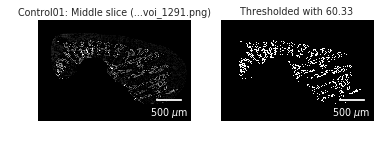

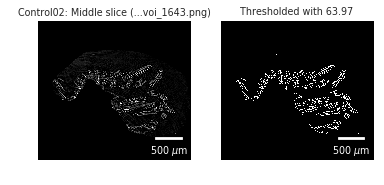

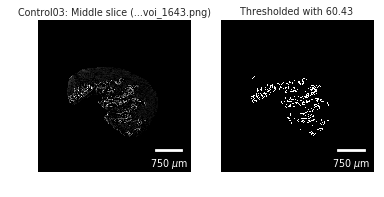

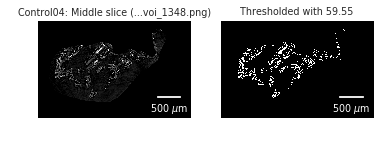

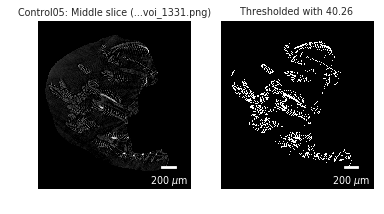

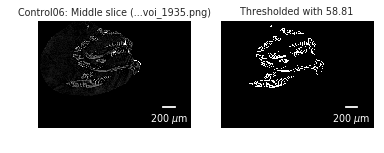

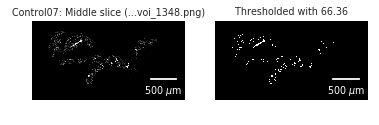

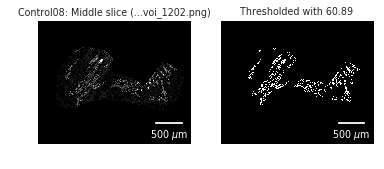

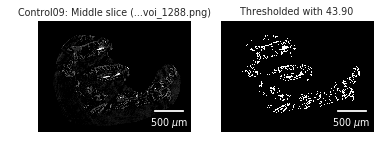

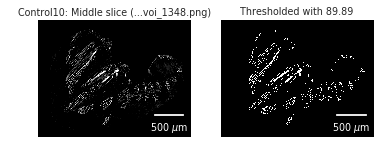

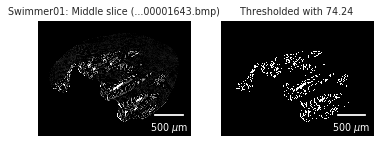

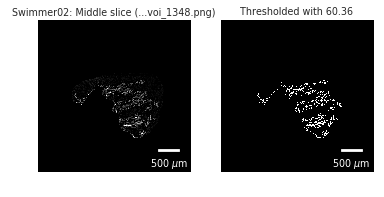

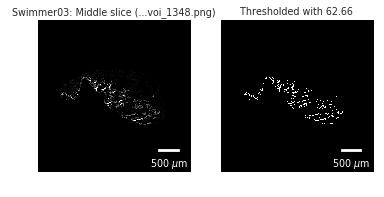

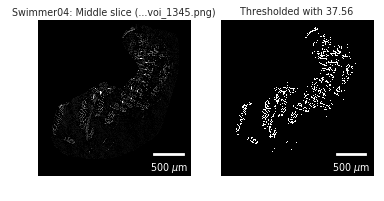

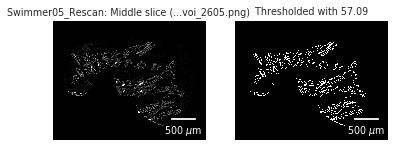

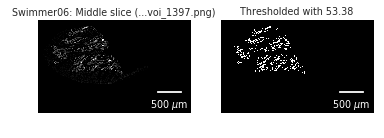

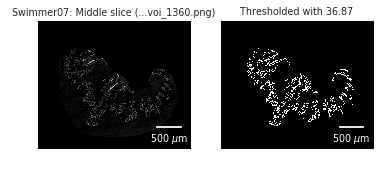

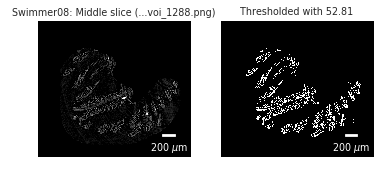

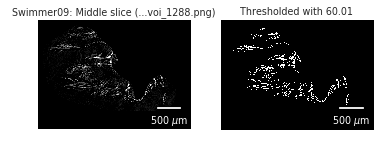

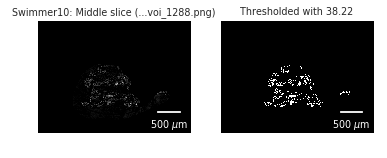

In [149]:
# Display middle slices and thresholded equivalent
for c, fish in Data.iterrows():
    plt.subplot(121)
    plt.imshow(VOIImages[c][len(VOIImages[c]) // 2])
    plt.title('%s: Middle slice (...%s)' % (fish.Sample, Data.VOINames[c][len(VOIImages[c]) // 2][-12:]))
    plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(Thresholded[c][len(Thresholded[c]) // 2])
    plt.title('Thresholded with %0.2f' % Data.ThresholdAverage[c])
    plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
    plt.axis('off')
    plt.savefig(os.path.join(OutPutDir, 'MiddleSlice.%s.png' % fish.Sample), bbox_inches = 'tight')
    plt.show()

In [64]:
# Save thresholded images out
SaveImages = True
if SaveImages:
    # Save thresholded images
    for c, folder in enumerate(Data.VOIFolder):
        CurrentOutputFolder = os.path.join(folder, os.path.splitext(os.path.basename(Data.OutputNameThresholded[c]))[0])
        if not os.path.exists(CurrentOutputFolder):
            os.makedirs(CurrentOutputFolder)
        if len(glob.glob(os.path.join(CurrentOutputFolder, '*.png'))) >= len(VOIImages[c]):
            print('%2s/%s: %s: Already saved %s thresholded images to %s' % (c + 1,
                                                                             len(Data),
                                                                             Data.Sample[c].rjust(namelenmax),
                                                                             len(VOIImages[c]),
                                                                             CurrentOutputFolder[len(RootFolder) + 1:]))
        else:
            print('%2s/%s: %s: Saving %s thresholded images to %s' % (c + 1,
                                                                      len(Data),
                                                                      Data.Sample[c].rjust(namelenmax),
                                                                      len(Thresholded[c]),
                                                                      CurrentOutputFolder[len(RootFolder) + 1:]))
            for d, i in enumerate(Thresholded[c]):
                scipy.misc.imsave(os.path.join(CurrentOutputFolder,
                                               Data.Sample[c] + '_thresholded_%04d.png' % d), i.astype('uint8') * 255)

 1/20:        Control01: Already saved 2338 thresholded images to Control01/VOI/VOI_thresholded-with-60.33
 2/20:        Control02: Already saved 3062 thresholded images to Control02/VOI/VOI_thresholded-with-63.97
 3/20:        Control03: Already saved 3062 thresholded images to Control03/VOI/VOI_thresholded-with-60.43
 4/20:        Control04: Already saved 2452 thresholded images to Control04/VOI/VOI_thresholded-with-59.55
 5/20:        Control05: Already saved 2642 thresholded images to Control05/VOI/VOI_thresholded-with-40.26
 6/20:        Control06: Already saved 3389 thresholded images to Control06/VOI/VOI_thresholded-with-58.81
 7/20:        Control07: Already saved 2452 thresholded images to Control07/VOI/VOI_thresholded-with-66.36
 8/20:        Control08: Already saved 2400 thresholded images to Control08/VOI/VOI_thresholded-with-60.89
 9/20:        Control09: Already saved 2572 thresholded images to Control09/VOI/VOI_thresholded-with-43.90
10/20:        Control10: Already save

In [65]:
# # Display some original slices through the VOIs
# SlicesToShow = 5
# Iterator = [int(round(len(r) / SlicesToShow)) for r in Data.VOINames]
# for c, sample in Data.iterrows():
#     for i in range(SlicesToShow):
#         plt.subplot(1,SlicesToShow,i+1)
#         plt.imshow(VOIImages[c][::Iterator[c]][i])
#         plt.axis('off')
#         if i:
#             plt.title('Slice %s' % i)
#         else:
#             plt.gca().add_artist(ScaleBar(sample.PixelSize, 'um', color='white'))
#             plt.title(sample.Sample)
#     plt.savefig(os.path.join(OutPutDir, 'Sampler_%s_%s-images_originals.png' % (sample.Sample, SlicesToShow)), bbox_inches = 'tight')
#     plt.show()

In [66]:
# # Display some thresholded slices through the VOIs
# for c, sample in Data.iterrows():
#     for i in range(SlicesToShow):
#         plt.subplot(1,SlicesToShow,i+1)
#         plt.imshow(Thresholded[c][::Iterator[c]][i])
#         plt.axis('off')
#         if i:
#             plt.title('Slice %s' % i)
#         else:
#             plt.gca().add_artist(ScaleBar(sample.PixelSize, 'um', color='white'))
#             plt.title(sample.Sample)
#     plt.savefig(os.path.join(OutPutDir, 'Sampler_%s_%s-images_thresholded.png' % (sample.Sample, SlicesToShow)), bbox_inches = 'tight')
#     plt.show()

In [67]:
# Read or generate the MIPs
Data['OutputNameMIP'] = [os.path.join(f,
                                      sample + '_MIP_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                      len(n)))
                         for f, sample, n, p in zip(Data.Folder,
                                                    Data.Sample,
                                                    Data.VOINames,
                                                    Data.PrintEverySlice)]
MIPs = [None] * len(Data)
for c, fn in enumerate(Data.OutputNameMIP):
    if os.path.exists(fn):
        print('%2s/%s: %16s: Loading %s into memory' % (c + 1,
                                                        len(Data),
                                                        Data.Sample[c],
                                                        fn[len(RootFolder):]))
        MIPs[c] = numpy.load(fn, mmap_mode='r')
    else:
        print('%2s/%s: %16s: Generating MIP from %s images' % (c + 1,
                                                               len(Data),
                                                               Data.Sample[c],
                                                               len(Data.SubsetNames[c])))
        MIPs[c] = numpy.max(VOISubset[c], axis=0)
        numpy.save(fn, MIPs[c], allow_pickle=False)
        # Free up memory
        VOISubset[c]._mmap.close()
        gc.collect()
    # Save MIP to PNG image
    scipy.misc.imsave(os.path.splitext(fn)[0] + '.png', MIPs[c])

 1/20:        Control01: Loading /Control01/Control01_MIP_from_2338_of_2338_slices.npy into memory
 2/20:        Control02: Loading /Control02/Control02_MIP_from_3062_of_3062_slices.npy into memory
 3/20:        Control03: Loading /Control03/Control03_MIP_from_3062_of_3062_slices.npy into memory
 4/20:        Control04: Loading /Control04/Control04_MIP_from_2452_of_2452_slices.npy into memory
 5/20:        Control05: Loading /Control05/Control05_MIP_from_2642_of_2642_slices.npy into memory
 6/20:        Control06: Loading /Control06/Control06_MIP_from_3389_of_3389_slices.npy into memory
 7/20:        Control07: Loading /Control07/Control07_MIP_from_2452_of_2452_slices.npy into memory
 8/20:        Control08: Loading /Control08/Control08_MIP_from_2400_of_2400_slices.npy into memory
 9/20:        Control09: Loading /Control09/Control09_MIP_from_2572_of_2572_slices.npy into memory
10/20:        Control10: Loading /Control10/Control10_MIP_from_2452_of_2452_slices.npy into memory
11/20:    

In [68]:
# Load (or memory-map) all the files again, since we closed them above.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [69]:
# # Display x,y,z-MIPs
# for c, sample in enumerate(VOISubset):
#     for ax in range(3):
#         plt.subplot(1,3,ax+1)
#         plt.imshow(numpy.max(sample, axis=ax))
#         plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#         plt.title('%s MIP axis %s' % (Data.Sample[c], ax))
#         plt.axis('off')
#     plt.show()

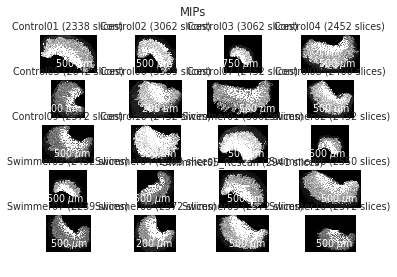

In [70]:
# Display calculated MIPs
for c, m in enumerate(MIPs):
    plt.subplot(lines, numpy.ceil(len(SampleNames) / float(lines)), c + 1)
    plt.imshow(m)
    plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
    plt.title('%s (%s slices)' % (SampleNames[c], len(Data.SubsetNames[c])))
    plt.axis('off')
plt.suptitle('MIPs')
plt.savefig(os.path.join(OutPutDir, 'MIPs_from%04dslices.png' % NumberOfImagesToShow), bbox_inches = 'tight')
plt.show()

In [71]:
# grab the thresholds in the 60-80% range of the respective values
split = 5
Selected = [sorted(t)[(split - 2) * len(t) // split:(split - 1) * len(t) // split] for t in Data.Threshold]
# mask the values of the threshold that are *not* in this range
Otsu_selected = [numpy.ma.masked_outside(o, numpy.min(sel), numpy.max(sel)) for o, sel in zip(Data.Threshold, Selected)]
# use the mean of this 60-80% value to threshold the datasets
Data['Threshold6080'] = [numpy.nanmean(os) for os in Otsu_selected]

In [72]:
# # Display the different thresholds
# for c, s in enumerate(SampleNames):
#     plt.plot(Data.Threshold[c], marker='', label='%s | Global Otsu Mean=%.2f | 60-80%% Otsu mean=%0.2f' % (s,
#                                                                                                            Data.ThresholdAverage[c],
#                                                                                                            Data.Threshold6080[c]),
#              c=seaborn.color_palette(n_colors=len(SampleNames))[c])
#     plt.plot(Otsu_selected[c], '.', ms=5, alpha=0.618,
#              c=seaborn.color_palette(n_colors=len(Data))[c])
# #     plt.legend(loc='best')
# plt.xlim([0, Data.NumberOfVOISlices.max()])
# plt.title('Otsu thresholds for each slice of each sample')
# plt.savefig(os.path.join(OutPutDir, 'Thresholds-all.png'), bbox_inches = 'tight')
# plt.show()

In [73]:
# # Compare global Otsu threshold, 60%-80% selected threshold and threshold from MIPs
# for c, s in enumerate(SampleNames):
#     print('For %s we have a' % s)
#     print('\t- 60-80%% selected threshold of %0.2f' % Data.Threshold6080[c])
#     print('\t- global Otsu threshold of %0.2f' % Data.ThresholdAverage[c])

In [74]:
# Show all (global) histograms
if not True:
    # This takes a while, since we 'ravel' all images from the subsets and calculate their histogram...
    for c, s in enumerate(SampleNames):
        plt.subplot(lines, numpy.ceil(len(SampleNames) / float(lines)), c + 1)
        plt.hist(numpy.array(VOISubset[c]).ravel(),
                 bins=32,
                 log=True,
                 color=Data.Color[c],
                 label='%s | %s VOI slices' % (s, len(VOISubset[c])))
        if CalculateAllThresholds:
            plt.axvline(Data.Threshold6080[c],
                        label='Selected Threshold: %0.2f' % Data.Threshold6080[c],
                        c=seaborn.color_palette()[2])
            plt.axvline(GlobalOtsu[c], label='Mean Otsu Threshold: %0.2f' % GlobalOtsu[c],
                        c=seaborn.color_palette()[3])
        plt.axvline(Otsu_MIP[c], label='MIP Otsu Threshold: %0.2f' % Otsu_MIP[c],
                    c=seaborn.color_palette()[4])
        plt.legend()
        plt.xlim([0, 255])
    plt.savefig(os.path.join(OutPutDir, 'Histograms_Thresholds_from%04dslices.png' % NumberOfImagesToShow), bbox_inches = 'tight')
    plt.show()

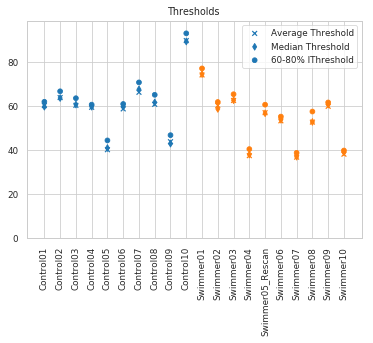

In [75]:
# Display the different thresholds
plt.scatter(x=Data.Sample, y=Data.ThresholdAverage, label='Average Threshold', c=Data.Color, marker='x')
plt.scatter(x=Data.Sample, y=Data.ThresholdMedian, label='Median Threshold', c=Data.Color, marker='d')
plt.scatter(x=Data.Sample, y=Data.Threshold6080, label='60-80% lThreshold', c=Data.Color)
plt.legend()
plt.ylim([0, Data.ThresholdAverage.max() * 1.1])
plt.xticks(rotation=90)
plt.title('Thresholds')
plt.show()

In [76]:
# # Show middle images with some data
# plt.rcParams['figure.figsize'] = (16, 5)
# for c, s in enumerate(SampleNames):
#     maximum = skimage.filters.rank.maximum(Data.MiddleSlice[c].astype('uint8'), skimage.morphology.disk(25))
#     plt.subplot(141)
#     plt.imshow(Data.MiddleSlice[c])
#     plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#     plt.title('Middle slice of %s' % s)
#     plt.axis('off')
#     plt.subplot(142)
#     plt.imshow(Data.MiddleSlice[c], vmax=0.618 * numpy.max(Data.MiddleSlice[c]))
#     plt.imshow(maximum, cmap='viridis', alpha=0.5)
#     plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#     plt.title('%s\nwith local maxima' % os.path.basename(Data.MiddleSliceName[c]))
#     plt.axis('off')
#     plt.subplot(143)
#     plt.hist(Data.MiddleSlice[c].ravel(), bins=32, log=True, color=Data.Color[c])
#     plt.axvline(Data.Threshold6080[c],
#                 label='60-80%% Threshold: %0.2f' % Data.Threshold6080[c],
#                 c=seaborn.color_palette()[2])
#     plt.axvline(Data.ThresholdAverage[c], label='Threshold Average: %0.2f' % Data.ThresholdAverage[c],
#                 c=seaborn.color_palette()[3])
#     plt.legend(loc='best')
#     plt.xlim([0, 255])
#     plt.title('Histogram of middle slice')
#     plt.subplot(144)
#     plt.imshow(MIPs[c])
#     plt.title('MIP of %s slices of %s' % (len(Data.SubsetNames[c]),
#                                           Data.Sample[c]))
#     plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
#     plt.axis('off')
#     plt.savefig(os.path.join(OutPutDir, 'Details_%s.png' % Data.Sample[c]), bbox_inches = 'tight')
#     plt.show()
# plt.rcParams['figure.figsize'] = (16, 9)

In [77]:
def calculate_area_gills(image, threshold=None):
    """
    This function calculates the gill area on an image.
    It is simply summing up all the thresholded pixels.
    """
    if not threshold:
        # Calculate the Otsu threshold of the image if needed
        try:
            threshold = skimage.filters.threshold_otsu(image)
        except (ValueError):
            threshold = 0
    thresholded_image = image > threshold
    area_gills = numpy.sum(thresholded_image)
    return(area_gills)

In [78]:
# Calculate the gill area (pythonic way, but without saving it in the middle...)
# Data['AreaGills'] = [[calculate_area_gills(i, threshold=t)
#                       for i, t in zip(subset, thrs)]
#                      for subset, thrs in zip(VOISubset, Data.Threshold)]

In [79]:
# Calculate the gill area (slow way, but with saving it in the middle...)
Data['OutputNameAreaGills'] = [os.path.join(f,
                                            sample + '_area_gills_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                   len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
# Don't save into the dataframe, or else we won't be able to make it :)
Data['AreaGills'] = [numpy.nan for file in Data.OutputNameAreaGills]
for c, subset in enumerate(VOISubset):
    # Only do this if we didn't do it already...
    if os.path.exists(Data.OutputNameAreaGills[c]):
        print('%2s/%s: %16s: Already saved to %s' % (c + 1,
                                                     len(Data.Sample),
                                                     Data.Sample[c],
                                                     Data.OutputNameAreaGills[c][len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Calculating gill area on %s of %s VOI images' % (c + 1,
                                                                              len(Data.Sample),
                                                                              Data.Sample[c],
                                                                              len(Data.SubsetNames[c]),
                                                                              len(Data.VOINames[c])))
        Data.AreaGills[c] = [None] * len(subset)
        for d, image in enumerate(subset):
            Data.AreaGills[c][d] = calculate_area_gills(image, threshold=Data.Threshold[c][d])
        print('%23s: Saving area to %s' % (Data.Sample[c], Data.OutputNameAreaGills[c][len(RootFolder):]))
        numpy.save(Data.OutputNameAreaGills[c], Data.AreaGills[c], allow_pickle=False)
        Data.AreaGills[c] = numpy.nan
        # Free up memory
        subset._mmap.close()
        gc.collect()

 1/20:        Control01: Already saved to /Control01/Control01_area_gills_from_2338_of_2338_slices.npy
 2/20:        Control02: Already saved to /Control02/Control02_area_gills_from_3062_of_3062_slices.npy
 3/20:        Control03: Already saved to /Control03/Control03_area_gills_from_3062_of_3062_slices.npy
 4/20:        Control04: Already saved to /Control04/Control04_area_gills_from_2452_of_2452_slices.npy
 5/20:        Control05: Already saved to /Control05/Control05_area_gills_from_2642_of_2642_slices.npy
 6/20:        Control06: Already saved to /Control06/Control06_area_gills_from_3389_of_3389_slices.npy
 7/20:        Control07: Already saved to /Control07/Control07_area_gills_from_2452_of_2452_slices.npy
 8/20:        Control08: Already saved to /Control08/Control08_area_gills_from_2400_of_2400_slices.npy
 9/20:        Control09: Already saved to /Control09/Control09_area_gills_from_2572_of_2572_slices.npy
10/20:        Control10: Already saved to /Control10/Control10_area_gills

In [80]:
# Load (or memory-map) all the files again, since we closed them above.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [81]:
# Save gills images out
for c, sample in Data.iterrows():
    sample['CurrentOutputFolder'] = os.path.join(os.path.dirname(sample.OutputNameVOI), 'VOI_thresholded_gills')
    if not os.path.exists(sample.CurrentOutputFolder):
        os.makedirs(sample.CurrentOutputFolder)
    if len(glob.glob(os.path.join(sample.CurrentOutputFolder, '*.png'))) >= sample.NumberOfAnalyzedVOISlices:
        print('%2s/%s: %7s: Already saved %3s thresholded images to %s' % (c + 1,
                                                                           len(Data),
                                                                           sample.Sample,
                                                                           sample.NumberOfAnalyzedVOISlices,
                                                                           sample.CurrentOutputFolder[len(RootFolder):]))
    else:
        print('%2s/%s: %7s: Saving %3s thresholded images to the disk' % (c + 1,
                                                                          len(Data),
                                                                          Data.Sample[c],
                                                                          sample.NumberOfAnalyzedVOISlices))
        for d, i in enumerate(VOISubset[c]):
            t = i > Data.Threshold[c][d]
            scipy.misc.imsave(os.path.join(sample.CurrentOutputFolder,
                                           sample.Sample + '_thresholded_gills_%04d.png' % d), t.astype('uint8') * 255)

 1/20: Control01: Already saved 2338 thresholded images to /Control01/VOI_thresholded_gills
 2/20: Control02: Already saved 3062 thresholded images to /Control02/VOI_thresholded_gills
 3/20: Control03: Already saved 3062 thresholded images to /Control03/VOI_thresholded_gills
 4/20: Control04: Already saved 2452 thresholded images to /Control04/VOI_thresholded_gills
 5/20: Control05: Already saved 2642 thresholded images to /Control05/VOI_thresholded_gills
 6/20: Control06: Already saved 3389 thresholded images to /Control06/VOI_thresholded_gills
 7/20: Control07: Already saved 2452 thresholded images to /Control07/VOI_thresholded_gills
 8/20: Control08: Already saved 2400 thresholded images to /Control08/VOI_thresholded_gills
 9/20: Control09: Already saved 2572 thresholded images to /Control09/VOI_thresholded_gills
10/20: Control10: Already saved 2452 thresholded images to /Control10/VOI_thresholded_gills
11/20: Swimmer01: Already saved 3062 thresholded images to /Swimmer01/VOI_thresh

In [82]:
def calculate_area_organ(image, threshold=None, verbose=False):
    """
    This function tries to estimate an organ area, e.g. the total organ area,
    discarding the small voids between the secondary filament.
    """
    if not threshold:
        # Calculate the Otsu threshold of the image if needed
        try:
            threshold = skimage.filters.threshold_otsu(image)
        except (ValueError):
            threshold = 0
    thresholded_image = image > threshold
    binary_closing = True
    if binary_closing:
        # Use simple binary closing
        closed = skimage.morphology.binary_closing(thresholded_image, selem=skimage.morphology.selem.disk(25))
    else:
        # Close small holes (this could be a bit more robust than simple binary closing)
        imagearea = numpy.shape(image)[0] * numpy.shape(image)[1]
        closed = skimage.morphology.remove_small_holes(thresholded_image, area_threshold=imagearea * 0.618)
    if verbose:
        # mask out Deas ROI
        masked = numpy.ma.masked_equal(image, 0)
        # Show the images
        plt.subplot(131)
        plt.imshow(masked.filled(0))
        plt.axis('off')
        plt.title('Original')
        plt.subplot(132)
        plt.imshow(thresholded_image)
        plt.axis('off')
        plt.title('Thresholded with %0.2f: %0.2g px' % (threshold, numpy.sum(thresholded_image)))
        plt.subplot(133)
        plt.imshow(closed)
        plt.axis('off')
        plt.title('Closed: %0.2g px' % numpy.sum(closed))
        plt.show()
    area_organ = numpy.sum(closed)
    return(area_organ)

In [83]:
# Calculate the (extrapolated) organ area (pythonic way, but without saving it in the middle...)
# Data['AreaOrgan'] = [[calculate_area_organ(i, threshold=t)
#                       for i, t in zip(subset, thrs)]
#                      for subset, thrs in zip(VOISubset, Data.Threshold)]

In [84]:
# Calculate the (extrapolated) organ area (slow way, but with saving it in the middle...)
Data['OutputNameAreaOrgan'] = [os.path.join(f,
                                            sample + '_area_organ_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                   len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
# Don't save into the dataframe, or else we won't be able to make it :)
Data['AreaOrgan'] = [numpy.nan for file in Data.OutputNameAreaOrgan]
for c, subset in enumerate(VOISubset):
    # Only do this if we didn't do it already...
    if os.path.exists(Data.OutputNameAreaOrgan[c]):
        print('%2s/%s: %16s: Already saved to %s' % (c + 1,
                                                     len(Data.Sample),
                                                     Data.Sample[c],
                                                     Data.OutputNameAreaOrgan[c][len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Calculating organ area on %s of %s VOI images' % (c + 1,
                                                                               len(Data.Sample),
                                                                               Data.Sample[c],
                                                                               len(Data.SubsetNames[c]),
                                                                               len(Data.VOINames[c])))
        Data.AreaOrgan[c] = [None] * len(subset)
        for d, image in enumerate(subset):
            print('Working on image %04s of %04s' % (d, len(Data.SubsetNames[c])), end="\r")
            Data.AreaOrgan[c][d] = calculate_area_organ(image, threshold=Data.Threshold[c][d])
        print('%23s: Saving area to %s' % (Data.Sample[c], Data.OutputNameAreaOrgan[c][len(RootFolder):]))
        numpy.save(Data.OutputNameAreaOrgan[c], Data.AreaOrgan[c], allow_pickle=False)
        Data.AreaOrgan[c] = numpy.nan
        # Free up memory
        subset._mmap.close()
        gc.collect()

 1/20:        Control01: Already saved to /Control01/Control01_area_organ_from_2338_of_2338_slices.npy
 2/20:        Control02: Already saved to /Control02/Control02_area_organ_from_3062_of_3062_slices.npy
 3/20:        Control03: Already saved to /Control03/Control03_area_organ_from_3062_of_3062_slices.npy
 4/20:        Control04: Already saved to /Control04/Control04_area_organ_from_2452_of_2452_slices.npy
 5/20:        Control05: Already saved to /Control05/Control05_area_organ_from_2642_of_2642_slices.npy
 6/20:        Control06: Already saved to /Control06/Control06_area_organ_from_3389_of_3389_slices.npy
 7/20:        Control07: Already saved to /Control07/Control07_area_organ_from_2452_of_2452_slices.npy
 8/20:        Control08: Already saved to /Control08/Control08_area_organ_from_2400_of_2400_slices.npy
 9/20:        Control09: Already saved to /Control09/Control09_area_organ_from_2572_of_2572_slices.npy
10/20:        Control10: Already saved to /Control10/Control10_area_organ

In [85]:
# Load (or memory-map) all the files again, since we closed them above.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [86]:
# Save organ area images out
for c, sample in Data.iterrows():
    sample['CurrentOutputFolder'] = os.path.join(os.path.dirname(sample.OutputNameVOI), 'VOI_organ_area')
    if not os.path.exists(sample.CurrentOutputFolder):
        os.makedirs(sample.CurrentOutputFolder)
    if len(glob.glob(os.path.join(sample.CurrentOutputFolder, '*.png'))) >= sample.NumberOfAnalyzedVOISlices:
        print('%2s/%s: %7s: Already saved %3s organ area images to %s' % (c + 1,
                                                                          len(Data),
                                                                          sample.Sample,
                                                                          sample.NumberOfAnalyzedVOISlices,
                                                                          sample.CurrentOutputFolder[len(RootFolder):]))
    else:
        print('%2s/%s: %7s: Saving %3s organ area images to the disk' % (c + 1,
                                                                         len(Data),
                                                                         Data.Sample[c],
                                                                         sample.NumberOfAnalyzedVOISlices))
        for d, i in enumerate(VOISubset[c]):
            thresholded = i > Data.Threshold[c][d]
            closed = skimage.morphology.binary_closing(thresholded, selem=skimage.morphology.selem.disk(25))
            scipy.misc.imsave(os.path.join(sample.CurrentOutputFolder,
                                           sample.Sample + '_area_organ_%04d.png' % d), closed.astype('uint8') * 255)

 1/20: Control01: Already saved 2338 organ area images to /Control01/VOI_organ_area
 2/20: Control02: Already saved 3062 organ area images to /Control02/VOI_organ_area
 3/20: Control03: Already saved 3062 organ area images to /Control03/VOI_organ_area
 4/20: Control04: Already saved 2452 organ area images to /Control04/VOI_organ_area
 5/20: Control05: Already saved 2642 organ area images to /Control05/VOI_organ_area
 6/20: Control06: Already saved 3389 organ area images to /Control06/VOI_organ_area
 7/20: Control07: Already saved 2452 organ area images to /Control07/VOI_organ_area
 8/20: Control08: Already saved 2400 organ area images to /Control08/VOI_organ_area
 9/20: Control09: Already saved 2572 organ area images to /Control09/VOI_organ_area
10/20: Control10: Already saved 2452 organ area images to /Control10/VOI_organ_area
11/20: Swimmer01: Already saved 3062 organ area images to /Swimmer01/VOI_organ_area
12/20: Swimmer02: Already saved 2452 organ area images to /Swimmer02/VOI_org

In [87]:
# Load the data in
Data['AreaGills'] = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameAreaGills]
Data['AreaOrgan'] = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameAreaOrgan]

In [88]:
# Sum the images to get the volume of the gills and organ
# This volume is obviously in voxels
Data['VolumeGills'] = [numpy.sum(ag) for ag in Data.AreaGills]
Data['VolumeOrgan'] = [numpy.sum(ao) for ao in Data.AreaOrgan]

In [89]:
# Calculate the volume in microliters
Data['VolumeGills_ul'] = [vg * vv for vg, vv in zip(Data.VolumeGills, Data.VoxelVolume)]
Data['VolumeOrgan_ul'] = [vo * vv for vo, vv in zip(Data.VolumeOrgan, Data.VoxelVolume)]

In [90]:
# Calculate the ratio of gills per organ
Data['GillsPerOrgan'] = [numpy.divide(ag, ao) for (ag, ao) in zip(Data['AreaGills'], Data['AreaOrgan'])]

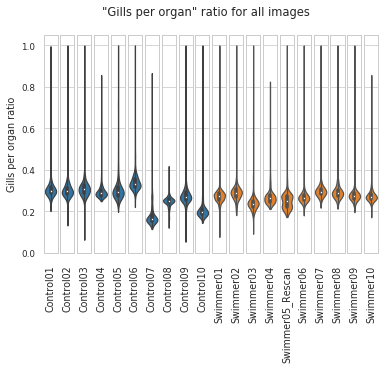

In [91]:
# Boxplots of the Areas
for c, a in enumerate(Data.GillsPerOrgan):
    plt.subplot(1, len(Data), c + 1)
    seaborn.violinplot(a, orient='v', color=Data.Color[c], cut=0)
#     seaborn.stripplot(a, orient='v', jitter=True, linewidth=1, s=5, color=Data.Color[c], alpha=0.318)
    plt.ylim([0, 1.05])
    if c:
        plt.gca().axes.yaxis.set_ticklabels([])
    else:
        plt.ylabel('Gills per organ ratio')
    plt.xlabel(Data.Sample[c], rotation=90)
plt.suptitle('"Gills per organ" ratio for all images')
plt.savefig(os.path.join(OutPutDir, 'Gills_per_organ_from%04dslices.png' % NumberOfImagesToShow), bbox_inches = 'tight')
plt.show()

In [92]:
# Calculate the mean 'gills per organ' ratio
Data['Mean_Gill_Ratio'] = [float(numpy.nanmean(a)) for a in Data['GillsPerOrgan']]

In [93]:
# Calculate the gill volume normalized to the fish length
Data['VolumeGillsNormalized'] = [numpy.divide(gv, w) for gv, w in zip(Data.VolumeGills_ul, Data.Length)]

----

Now that we have all the data let's display all that we need!
The plots below are the ones that are shown in the manuscript.

In [94]:
# Change color palette from the default
# seaborn.set_palette(seaborn.color_palette('viridis', 2))

In [95]:
p_values_training = pandas.concat([pandas.DataFrame(index=Speed.Training.unique(),
                                                    columns=Speed.Experiment.unique()),
                                   pandas.DataFrame(index=itertools.combinations(Speed.Training.unique(), 2),
                                                    columns=Speed.Experiment.unique())])
p_values_training['Control vs. Swimmer'] = numpy.nan

In [96]:
# Are there differences between control and swimmers?
for training in Speed.Training.unique():
    print(80*'-')
    t_statistic, p_value = scipy.stats.ttest_ind(Speed[(Speed.Training == training) &
                                                       (Speed.Experiment == 'Control')].Seconds.dropna(),
                                             Speed[(Speed.Training == training) &
                                                   (Speed.Experiment == 'Swimmer')].Seconds.dropna(),
                                             equal_var=True)
    p_values_training['Control vs. Swimmer'][training] = p_value / 2
    print("At %s, the duration for 'Control' and 'Swimmer' has an" % training)
    # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
    print('F value of %0.4s and a p value of %.2g (%s).' % (t_statistic, p_value / 2, significance(p_value/2)))


--------------------------------------------------------------------------------
At Before, the duration for 'Control' and 'Swimmer' has an
F value of 0.77 and a p value of 0.22 (not significant (p=0.223)).
--------------------------------------------------------------------------------
At 3 wk, the duration for 'Control' and 'Swimmer' has an
F value of nan and a p value of nan (not significant (p=nan)).
--------------------------------------------------------------------------------
At 5 wk, the duration for 'Control' and 'Swimmer' has an
F value of -5.0 and a p value of 5.7e-06 (**** (p=5.74e-06)).


In [97]:
# Are the durations between trainings different?
for experiment in Speed.Experiment.unique():
    for trainings in itertools.combinations(Speed.Training.unique(), 2):
        print(80*'-')
        t_statistic, p_value = scipy.stats.ttest_ind(Speed[(Speed.Training == trainings[0]) &
                                                           (Speed.Experiment == experiment)].Seconds.dropna(),
                                                     Speed[(Speed.Training == trainings[1]) &
                                                           (Speed.Experiment == experiment)].Seconds.dropna(),
                                                     equal_var=True)
        p_values_training[experiment][trainings] = p_value / 2
        print("For the %s group, the data between '%s' and '%s' has an" % (experiment,
                                                                           trainings[0],
                                                                           trainings[1]))
        # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
        print('F value of %0.4s and a p value of %.2g. (%s)' % (t_statistic, p_value / 2, significance(p_value/2)))

--------------------------------------------------------------------------------
For the Control group, the data between 'Before' and '3 wk' has an
F value of nan and a p value of nan. (not significant (p=nan))
--------------------------------------------------------------------------------
For the Control group, the data between 'Before' and '5 wk' has an
F value of -1.5 and a p value of 0.066. (not significant (p=0.0665))
--------------------------------------------------------------------------------
For the Control group, the data between '3 wk' and '5 wk' has an
F value of nan and a p value of nan. (not significant (p=nan))
--------------------------------------------------------------------------------
For the Swimmer group, the data between 'Before' and '3 wk' has an
F value of -3.8 and a p value of 0.00023. (*** (p=0.000231))
--------------------------------------------------------------------------------
For the Swimmer group, the data between 'Before' and '5 wk' has an
F valu

In [98]:
p_values_training

,Control,Swimmer,Control vs. Swimmer
Before,NaN,NaN,0.222579
3 wk,NaN,NaN,NaN
5 wk,NaN,NaN,0.000006
"(Before, 3 wk)",NaN,0.000231366,NaN
"(Before, 5 wk)",0.0664629,2.96772e-08,NaN
"(3 wk, 5 wk)",NaN,0.11232,NaN


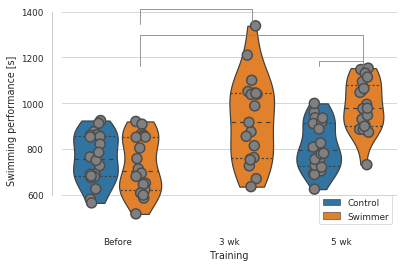

In [99]:
# Plot the speed data
import matplotlib.dates as mdates
seaborn.violinplot(data=Speed, hue='Experiment', y='Seconds', x='Training', cut=0, inner='quartiles')
seaborn.stripplot(data=Speed, hue='Experiment', y='Seconds', x='Training',
                  dodge=True, s=10, linewidth=1.5,
                  palette=['gray', 'gray'])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2], loc='lower right')
plt.ylabel('Swimming performance [s]')

# Highlight significant values
plt.gca().annotate('',
                   xy=(2-0.2, Speed[(Speed.Training == '5 wk')].Seconds.max()),
                   xycoords='data',
                   xytext=(2+0.2, Speed[(Speed.Training == '5 wk')].Seconds.max()),
                   textcoords='data',
                   arrowprops=dict(arrowstyle="-", ec='gray', connectionstyle="bar, angle=180, fraction=0.15"))
plt.gca().annotate('',
                   xy=(0+0.2, numpy.maximum(Speed[(Speed.Experiment == 'Swimmer') &
                                                   (Speed.Training == 'Before')].Seconds.max(),
                                             Speed[(Speed.Experiment == 'Swimmer') &
                                                   (Speed.Training == '3 wk')].Seconds.max())),
                   xycoords='data',
                   xytext=(1+0.2, numpy.maximum(Speed[(Speed.Experiment == 'Swimmer') &
                                                       (Speed.Training == 'Before')].Seconds.max(),
                                                 Speed[(Speed.Experiment == 'Swimmer') &
                                                       (Speed.Training == '3 wk')].Seconds.max())),
                   textcoords='data',
                   arrowprops=dict(arrowstyle="-", ec='gray', connectionstyle="bar, angle=180, fraction=0.15"))
plt.gca().annotate('',
                   xy=(0+0.2, numpy.maximum(Speed[(Speed.Experiment == 'Swimmer') &
                                                   (Speed.Training == 'Before')].Seconds.max(),
                                             Speed[(Speed.Experiment == 'Swimmer') &
                                                   (Speed.Training == '5 wk')].Seconds.max())),
                   xycoords='data',
                   xytext=(2+0.2, numpy.maximum(Speed[(Speed.Experiment == 'Swimmer') &
                                                       (Speed.Training == 'Before')].Seconds.max(),
                                                 Speed[(Speed.Experiment == 'Swimmer') &
                                                       (Speed.Training == '5 wk')].Seconds.max())),
                   textcoords='data',
                   arrowprops=dict(arrowstyle="-", ec='gray', connectionstyle="bar, angle=180, fraction=0.15"))
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'Endurance.png'), bbox_inches = 'tight')
plt.show()

In [100]:
# Data as prose
for experiment in Speed.Experiment.unique():
    print(80*'-')
    for training in Speed.Training.unique():
        print('The endurance of the %s group at %s training was %s min %s sec '
              'with a STD of %s min %s sec.' % (experiment,
                                                training,
                                                pandas.to_datetime(Speed[(Speed.Experiment == experiment) &
                                                                  (Speed.Training == training)].Seconds.mean(),
                                                            unit='s').minute,
                                                pandas.to_datetime(Speed[(Speed.Experiment == experiment) &
                                                                  (Speed.Training == training)].Seconds.mean(),
                                                            unit='s').second,
                                                pandas.to_datetime(Speed[(Speed.Experiment == experiment) &
                                                                  (Speed.Training == training)].Seconds.std(),
                                                            unit='s').minute,
                                                pandas.to_datetime(Speed[(Speed.Experiment == experiment) &
                                                                  (Speed.Training == training)].Seconds.std(),
                                                            unit='s').second))

--------------------------------------------------------------------------------
The endurance of the Control group at Before training was 12 min 38 sec with a STD of 1 min 48 sec.
The endurance of the Control group at 3 wk training was nan min nan sec with a STD of nan min nan sec.
The endurance of the Control group at 5 wk training was 13 min 30 sec with a STD of 1 min 46 sec.
--------------------------------------------------------------------------------
The endurance of the Swimmer group at Before training was 12 min 9 sec with a STD of 2 min 5 sec.
The endurance of the Swimmer group at 3 wk training was 15 min 26 sec with a STD of 3 min 10 sec.
The endurance of the Swimmer group at 5 wk training was 16 min 29 sec with a STD of 1 min 54 sec.


In [101]:
for experiment in Speed.Experiment.unique():
    print(80*'-')
    for trainings in itertools.combinations(Speed.Training.unique(),2):
        print('The speed of the %s '
              'increased by %0.2f %% between '
              '"%s" and "%s"' % (experiment,
                                 percentage(Speed[(Speed.Experiment == experiment) &
                                                  (Speed.Training == trainings[0])].Seconds.mean(),
                                            Speed[(Speed.Experiment == experiment) &
                                                  (Speed.Training == trainings[1])].Seconds.mean()),
                                  trainings[0],
                                  trainings[1]))

--------------------------------------------------------------------------------
The speed of the Control increased by nan % between "Before" and "3 wk"
The speed of the Control increased by 6.90 % between "Before" and "5 wk"
The speed of the Control increased by nan % between "3 wk" and "5 wk"
--------------------------------------------------------------------------------
The speed of the Swimmer increased by 27.01 % between "Before" and "3 wk"
The speed of the Swimmer increased by 35.62 % between "Before" and "5 wk"
The speed of the Swimmer increased by 6.78 % between "3 wk" and "5 wk"


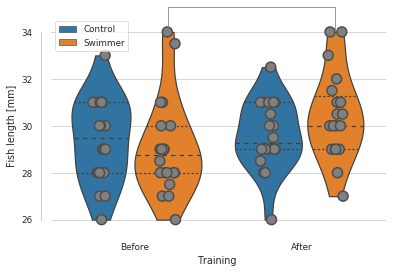

In [102]:
# Display fish length
seaborn.violinplot(data=Morphology, hue='Experiment', y='Length', x='Training', cut=0, inner='quartiles')
seaborn.stripplot(data=Morphology, hue='Experiment', y='Length', x='Training',
                  dodge=True, s=10, linewidth=1.5,
                  palette=['gray', 'gray'])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2], loc='upper left')
plt.ylabel('Fish length [mm]')
# Highlight significant values
plt.gca().annotate('',
                   xy=(0+0.2, Morphology[(Morphology.Experiment == 'Swimmer')].Length.max()),
                   xycoords='data',
                   xytext=(1+0.2, Morphology[(Morphology.Experiment == 'Swimmer')].Length.max()),
                   textcoords='data',
                   arrowprops=dict(arrowstyle="-", ec='gray', connectionstyle="bar, angle=180, fraction=0.15"))
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'Lengths.png'), bbox_inches = 'tight')
plt.show()

In [103]:
# Are there differences between control and swimmers?
for training in Morphology.Training.unique():
    print(80*'-')
    t_statistic, p_value = scipy.stats.ttest_ind(Morphology[(Morphology.Training == training) &
                                                            (Morphology.Experiment == 'Control')].Length.dropna(),
                                                 Morphology[(Morphology.Training == training) &
                                                            (Morphology.Experiment == 'Swimmer')].Length.dropna(),
                                                 equal_var=True)
    print("At %s, the 'lengths' for 'Control' and 'Swimmer' have a" % training)
    # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
    print('F value of %0.4s and a p value of %.2g (%s).' % (t_statistic, p_value / 2, significance(p_value/2)))

--------------------------------------------------------------------------------
At Before, the 'lengths' for 'Control' and 'Swimmer' have a
F value of 0.53 and a p value of 0.3 (not significant (p=0.298)).
--------------------------------------------------------------------------------
At After, the 'lengths' for 'Control' and 'Swimmer' have a
F value of -1.5 and a p value of 0.061 (not significant (p=0.0614)).


In [104]:
# Are the lengths between trainings different?
for experiment in Morphology.Experiment.unique():
    for trainings in itertools.combinations(Morphology.Training.unique(), 2):
        print(80*'-')
        t_statistic, p_value = scipy.stats.ttest_ind(Morphology[(Morphology.Training == trainings[0]) &
                                                                (Morphology.Experiment == experiment)].Length.dropna(),
                                                     Morphology[(Morphology.Training == trainings[1]) &
                                                                (Morphology.Experiment == experiment)].Length.dropna(),
                                                     equal_var=True)
        print("For the %s group, the 'length' between '%s' and '%s' has an" % (experiment,
                                                                              trainings[0],
                                                                              trainings[1]))
        # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
        print('F value of %0.4s and a p value of %.2g. (%s)' % (t_statistic, p_value / 2, significance(p_value/2)))

--------------------------------------------------------------------------------
For the Control group, the 'length' between 'Before' and 'After' has an
F value of -0.3 and a p value of 0.35. (not significant (p=0.351))
--------------------------------------------------------------------------------
For the Swimmer group, the 'length' between 'Before' and 'After' has an
F value of -2.1 and a p value of 0.018. (* (p=0.0178))


In [105]:
# Data as prose
for experiment in Morphology.Experiment.unique():
    print(80*'-')
    for training in Morphology.Training.unique():
        print('The length of the %s group %s training '
              'was %0.2f mm with a STD of %0.2f.' % (experiment,
                                                     training,
                                                     Morphology[(Morphology.Experiment == experiment) &
                                                                (Morphology.Training == training)].Length.mean(),
                                                     Morphology[(Morphology.Experiment == experiment) &
                                                                (Morphology.Training == training)].Length.std()))

--------------------------------------------------------------------------------
The length of the Control group Before training was 29.40 mm with a STD of 1.79.
The length of the Control group After training was 29.60 mm with a STD of 1.47.
--------------------------------------------------------------------------------
The length of the Swimmer group Before training was 29.07 mm with a STD of 2.05.
The length of the Swimmer group After training was 30.45 mm with a STD of 1.87.


In [106]:
for experiment in Morphology.Experiment.unique():
    for trainings in itertools.combinations(Morphology.Training.unique(), 2):
        print('The length of the %s '
              'increased by %0.2f %% between '
              '"%s" and "%s"' % (experiment, 
                                 percentage(Morphology[(Morphology.Experiment == experiment) &
                                                      (Morphology.Training == trainings[0])].Length.mean(),
                                            Morphology[(Morphology.Experiment == experiment) &
                                                  (Morphology.Training == trainings[1])].Length.mean()),
                                  trainings[0],
                                  trainings[1]))

The length of the Control increased by 0.68 % between "Before" and "After"
The length of the Swimmer increased by 4.72 % between "Before" and "After"


In [107]:
# Are there differences between control and swimmers?
for training in Morphology.Training.unique():
    print(80*'-')
    t_statistic, p_value = scipy.stats.ttest_ind(Morphology[(Morphology.Gender == 'Male') &
                                                            (Morphology.Training == training) &
                                                            (Morphology.Experiment == 'Control')].Weight.dropna(),
                                                 Morphology[(Morphology.Gender == 'Male') &
                                                            (Morphology.Training == training) &
                                                            (Morphology.Experiment == 'Swimmer')].Weight.dropna(),
                                                 equal_var=True)
    print("At %s, the weight for 'Control' and 'Swimmer' has an" % training)
    # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
    print('F value of %0.4s and a p value of %.2g (%s).' % (t_statistic, p_value / 2, significance(p_value/2)))

--------------------------------------------------------------------------------
At Before, the weight for 'Control' and 'Swimmer' has an
F value of 0.23 and a p value of 0.41 (not significant (p=0.408)).
--------------------------------------------------------------------------------
At After, the weight for 'Control' and 'Swimmer' has an
F value of -1.8 and a p value of 0.041 (* (p=0.0414)).


In [108]:
# Are the weights between trainings different?
for experiment in Morphology.Experiment.unique():
    for trainings in itertools.combinations(Morphology.Training.unique(), 2):
        print(80*'-')
        t_statistic, p_value = scipy.stats.ttest_ind(Morphology[(Morphology.Gender == 'Male') &
                                                                (Morphology.Training == trainings[0]) &
                                                                (Morphology.Experiment == experiment)].Length.dropna(),
                                                     Morphology[(Morphology.Gender == 'Male') &
                                                                (Morphology.Training == trainings[1]) &
                                                                (Morphology.Experiment == experiment)].Length.dropna(),
                                                     equal_var=True)
        print("For the %s group, the weight between '%s' and '%s' has an" % (experiment,
                                                                             trainings[0],
                                                                             trainings[1]))
        # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
        print('F value of %0.4s and a p value of %.2g. (%s)' % (t_statistic, p_value / 2, significance(p_value/2)))

--------------------------------------------------------------------------------
For the Control group, the weight between 'Before' and 'After' has an
F value of -0.9 and a p value of 0.18. (not significant (p=0.181))
--------------------------------------------------------------------------------
For the Swimmer group, the weight between 'Before' and 'After' has an
F value of -2.6 and a p value of 0.0083. (** (p=0.00827))


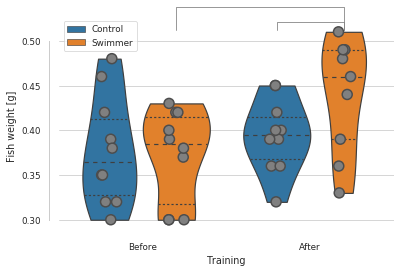

In [109]:
# Display male fish weight
seaborn.violinplot(data=Morphology[Morphology.Gender == 'Male'], hue='Experiment', y='Weight', x='Training',
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Morphology[Morphology.Gender == 'Male'], hue='Experiment', y='Weight', x='Training',
                  dodge=True, s=10, linewidth=1.5,
                  palette=['gray', 'gray'])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2], loc='upper left')
plt.ylabel('Fish weight [g]')
# Highlight significant values
plt.gca().annotate('',
                   xy=(1-0.2, Morphology[(Morphology.Gender == 'Male') &
                                         (Morphology.Training == 'After')].Weight.max()),
                   xycoords='data',
                   xytext=(1+0.2, Morphology[(Morphology.Gender == 'Male') &
                                         (Morphology.Training == 'After')].Weight.max()),
                   textcoords='data',
                   arrowprops=dict(arrowstyle="-", ec='gray', connectionstyle="bar, angle=180, fraction=0.15"))

plt.gca().annotate('',
                   xy=(0+0.2, Morphology[(Morphology.Gender == 'Male') &
                                         (Morphology.Experiment == 'Swimmer')].Weight.max()),
                   xycoords='data',
                   xytext=(1+0.2, Morphology[(Morphology.Gender == 'Male') &
                                         (Morphology.Experiment == 'Swimmer')].Weight.max()),
                   textcoords='data',
                   arrowprops=dict(arrowstyle="-", ec='gray', connectionstyle="bar, angle=180, fraction=0.15"))
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'Weights.png'), bbox_inches = 'tight')
plt.show()

In [110]:
# Data as prose
for experiment in Morphology.Experiment.unique():
    print(80*'-')
    for training in Morphology.Training.unique():
        print('The length of the %s group %s training '
              'was %0.2f mm with a STD of %0.2f.' % (experiment,
                                                     training,
                                                     Morphology[(Morphology.Experiment == experiment) &
                                                                (Morphology.Training == training)].Length.mean(),
                                                     Morphology[(Morphology.Experiment == experiment) &
                                                                (Morphology.Training == training)].Length.std()))

--------------------------------------------------------------------------------
The length of the Control group Before training was 29.40 mm with a STD of 1.79.
The length of the Control group After training was 29.60 mm with a STD of 1.47.
--------------------------------------------------------------------------------
The length of the Swimmer group Before training was 29.07 mm with a STD of 2.05.
The length of the Swimmer group After training was 30.45 mm with a STD of 1.87.


In [111]:
# Data as prose
for experiment in Morphology.Experiment.unique():
    print(80*'-')
    for training in Morphology.Training.unique():
        print('The weight of the male %s group %s training '
              'was %0.3f g with a STD of %0.3f.' % (experiment,
                                                    training,
                                                    Morphology[(Morphology.Gender == 'Male') &
                                                               (Morphology.Experiment == experiment) &
                                                               (Morphology.Training == training)].Weight.mean(),
                                                    Morphology[(Morphology.Gender == 'Male') &
                                                               (Morphology.Experiment == experiment) &
                                                               (Morphology.Training == training)].Weight.std()))

--------------------------------------------------------------------------------
The weight of the male Control group Before training was 0.377 g with a STD of 0.061.
The weight of the male Control group After training was 0.394 g with a STD of 0.041.
--------------------------------------------------------------------------------
The weight of the male Swimmer group Before training was 0.371 g with a STD of 0.052.
The weight of the male Swimmer group After training was 0.439 g with a STD of 0.064.


In [112]:
for experiment in Morphology.Experiment.unique():
    for trainings in itertools.combinations(Morphology.Training.unique(), 2):
        print('The weight of the male %s '
              'increased by %0.2f %% between '
              '"%s" and "%s"' % (experiment, 
                                 percentage(Morphology[(Morphology.Gender == 'Male') &
                                                       (Morphology.Experiment == experiment) &
                                                       (Morphology.Training == trainings[0])].Weight.mean(),
                                            Morphology[(Morphology.Gender == 'Male') &
                                                       (Morphology.Experiment == experiment) &
                                                       (Morphology.Training == trainings[1])].Weight.mean()),
                                 trainings[0],
                                 trainings[1]))

The weight of the male Control increased by 4.51 % between "Before" and "After"
The weight of the male Swimmer increased by 18.30 % between "Before" and "After"


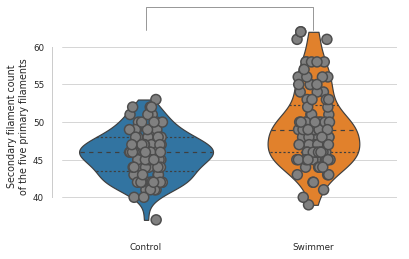

In [113]:
# Display filament count
seaborn.violinplot(data=Filaments[['Control Count', 'Swimmer Count']],
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Filaments[['Control Count', 'Swimmer Count']],
                  s=10, linewidth=1.5, color='gray')
# statistical annotation, see bottom of https://github.com/jbmouret/matplotlib_for_papers
plt.gca().annotate('',
                   xy=(0, numpy.max(Filaments[['Control Count', 'Swimmer Count']].max())),
                   xycoords='data',
                   xytext=(1, numpy.max(Filaments[['Control Count', 'Swimmer Count']].max())),
                   textcoords='data',
                   arrowprops=dict(arrowstyle="-", ec='gray', connectionstyle="bar, angle=180, fraction=0.15"))
plt.ylabel('Secondary filament count\nof the five primary filaments')
plt.gca().set_xticklabels(['Control', 'Swimmer'])
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'Filament_count.png'), bbox_inches = 'tight')
plt.show()

In [114]:
# Are the filament counts between trainings different?

t_statistic, p_value = scipy.stats.ttest_ind(Filaments['Control Count'].dropna(),
                                             Filaments['Swimmer Count'].dropna(),
                                             equal_var=True)
print("The filament count between 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
print('F value of %0.4s and a p value of %.2g. (%s)' % (t_statistic, p_value / 2, significance(p_value/2)))

The filament count between 'Control' and 'Swimmer' has an
F value of -5.8 and a p value of 9e-09. (**** (p=8.95e-09))


In [115]:
# Data as prose
for experiment in Morphology.Experiment.unique():
    print(80*'-')
    for training in Morphology.Training.unique():
        print('The length of the %s group %s training '
              'was %0.2f mm with a STD of %0.2f.' % (experiment,
                                                     training,
                                                     Morphology[(Morphology.Experiment == experiment) &
                                                                (Morphology.Training == training)].Length.mean(),
                                                     Morphology[(Morphology.Experiment == experiment) &
                                                                (Morphology.Training == training)].Length.std()))

--------------------------------------------------------------------------------
The length of the Control group Before training was 29.40 mm with a STD of 1.79.
The length of the Control group After training was 29.60 mm with a STD of 1.47.
--------------------------------------------------------------------------------
The length of the Swimmer group Before training was 29.07 mm with a STD of 2.05.
The length of the Swimmer group After training was 30.45 mm with a STD of 1.87.


In [116]:
# Data as prose
print('The mean secondary filament count for the control group was %0.2f with a STD of %0.2f.' % (Filaments['Control Count'].mean(),
                                                                                                  Filaments['Control Count'].std()))
print('The mean secondary filament count for the swimmers group was %0.2f with a STD of %0.2f.' % (Filaments['Swimmer Count'].mean(),
                                                                                                   Filaments['Swimmer Count'].std()))


The mean secondary filament count for the control group was 45.73 with a STD of 3.13.
The mean secondary filament count for the swimmers group was 49.27 with a STD of 5.02.


In [117]:
print('This is an increase of %0.2f %%' % percentage(Filaments['Control Count'].mean(), Filaments['Swimmer Count'].mean()))

This is an increase of 7.75 %


In [118]:
# Are the filament counts between trainings different?

t_statistic, p_value = scipy.stats.ttest_ind(Filaments['Control Length'].dropna(),
                                             Filaments['Swimmer Length'].dropna(),
                                             equal_var=True)
print("The filament length between 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
print('F value of %0.4s and a p value of %.2g. (%s)' % (t_statistic, p_value / 2, significance(p_value/2)))

The filament length between 'Control' and 'Swimmer' has an
F value of -3.3 and a p value of 0.00043. (*** (p=0.000435))


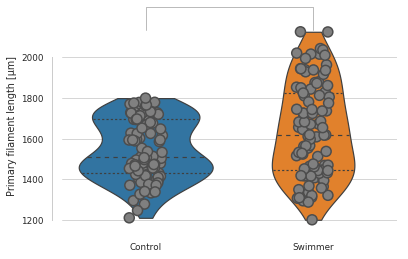

In [119]:
# Display filament length
seaborn.violinplot(data=Filaments[['Control Length', 'Swimmer Length']],
                   cut=0, inner='quartiles')
seaborn.stripplot(data=Filaments[['Control Length', 'Swimmer Length']],
                  s=10, linewidth=1.5, color='gray')
# statistical annotation, see bottom of https://github.com/jbmouret/matplotlib_for_papers
plt.gca().annotate('',
                   xy=(0, numpy.max(Filaments[['Control Length', 'Swimmer Length']].max())),
                   xycoords='data',
                   xytext=(1, numpy.max(Filaments[['Control Length', 'Swimmer Length']].max())),
                   textcoords='data',
                   arrowprops=dict(arrowstyle="-", ec='#aaaaaa', connectionstyle="bar, angle=180, fraction=0.15"))
plt.ylabel(u'Primary filament length [\u03bcm]')
plt.gca().set_xticklabels(['Control', 'Swimmer'])
seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'Filament_lenght.png'), bbox_inches = 'tight')
plt.show()

In [120]:
# Data as prose
print('The mean filament length for the control was %0.f um with a STD of %0.f.' % (Filaments['Control Length'].mean(),
                                                                                    Filaments['Control Length'].std()))
print('The mean filament length for the swimmers was %0.f um with a STD of %0.f.' % (Filaments['Swimmer Length'].mean(),
                                                                                     Filaments['Swimmer Length'].std()))

The mean filament length for the control was 1545 um with a STD of 148.
The mean filament length for the swimmers was 1639 um with a STD of 228.


In [121]:
print('This is an increase of %0.2f %%' % percentage(Filaments['Control Length'].mean(), Filaments['Swimmer Length'].mean()))

This is an increase of 6.06 %


Display the area mean (after we did some statistics)

In [122]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(Data.Mean_Gill_Ratio)
# nicht signifikant von Normalverteilung unterschiedlich

(0.9366322159767151, 0.20694465935230255)

In [123]:
# Levene -> Varianztest
scipy.stats.levene(Data.loc[Data.Experiment == 'Control'].Mean_Gill_Ratio,
                   Data.loc[Data.Experiment == 'Swimmer'].Mean_Gill_Ratio)
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

LeveneResult(statistic=3.384155056527279, pvalue=0.08237871281366123)

In [124]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(Data.loc[Data.Experiment == 'Control'].Mean_Gill_Ratio,
                     Data.loc[Data.Experiment == 'Swimmer'].Mean_Gill_Ratio)
# nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

Ks_2sampResult(statistic=0.5, pvalue=0.11084033741322809)

In [125]:
# Are the means different?
t_statistic, p_value = scipy.stats.ttest_ind(Data.loc[Data.Experiment == 'Control'].Mean_Gill_Ratio,
                                             Data.loc[Data.Experiment == 'Swimmer'].Mean_Gill_Ratio,
                                             equal_var=True)
print("The difference between the 'Mean_Gill_Ratio' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
print('F value of %0.4s and a p value of %.2g.' % (t_statistic, p_value / 2))

The difference between the 'Mean_Gill_Ratio' of 'Control' and 'Swimmer' has an
F value of 0.17 and a p value of 0.43.


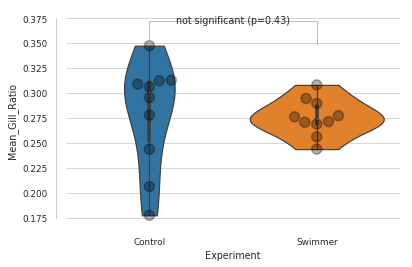

In [126]:
# Boxplot of the mean area for each animal (calculated slice-wise)
seaborn.violinplot(data=Data, x='Experiment', y='Mean_Gill_Ratio', cut=0)
seaborn.swarmplot(data=Data, x='Experiment', y='Mean_Gill_Ratio', s=10, linewidth=1.5,
                  color='k', alpha=0.309)
label = False
if label:
    shift = 0.1
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.Mean_Gill_Ratio[c]),
                               horizontalalignment='left', verticalalignment='bottom')
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.Mean_Gill_Ratio[c]),
                               horizontalalignment='left', verticalalignment='bottom')
# plt.title('Average "gills per organ" from slices')
plt.ylim(ymax=Data.Mean_Gill_Ratio.max() * 1.1)
# statistical annotation, see bottom of https://github.com/jbmouret/matplotlib_for_papers
plt.gca().annotate('',
                   xy=(0, Data.Mean_Gill_Ratio.max()),
                   xycoords='data',
                   xytext=(1, Data.Mean_Gill_Ratio.max()),
                   textcoords='data',
                   arrowprops=dict(arrowstyle="-", ec='#aaaaaa', connectionstyle="bar, fraction=0.15"))
plt.gca().text(0.5,
               Data.Mean_Gill_Ratio.max() + abs(Data.Mean_Gill_Ratio.max() - Data.Mean_Gill_Ratio.min()) * 0.15,
               significance(p_value / 2),
               horizontalalignment='center',
               verticalalignment='center')
seaborn.despine(offset=10, trim=True, bottom=True)
if label:
    plt.savefig(os.path.join(OutPutDir,
                             'Gills_per_organ_average_slices_from%04dslices.png' % NumberOfImagesToShow),
                bbox_inches = 'tight')
else:
    plt.savefig(os.path.join(OutPutDir,
                             'Gills_per_organ_average_slices_from%04dslices_nolabels.png' % NumberOfImagesToShow),
                bbox_inches = 'tight')
plt.show()

Display the volume data (after we did some statistics)

In [127]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(Data.VolumeGills)
# nicht signifikant von Normalverteilung unterschiedlich

(0.9144847393035889, 0.07763797044754028)

In [128]:
# Levene -> Varianztest
scipy.stats.levene(Data.loc[Data.Experiment == 'Control'].VolumeGills,
                   Data.loc[Data.Experiment == 'Swimmer'].VolumeGills)
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

LeveneResult(statistic=0.5468692212197214, pvalue=0.46913511203835245)

In [129]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(Data.loc[Data.Experiment == 'Control'].VolumeGills,
                     Data.loc[Data.Experiment == 'Swimmer'].VolumeGills)
# nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

Ks_2sampResult(statistic=0.4, pvalue=0.3128526760169558)

In [130]:
# Are the means different?
t_statistic, p_value = scipy.stats.ttest_ind(Data.loc[Data.Experiment == 'Control'].VolumeGills,
                                             Data.loc[Data.Experiment == 'Swimmer'].VolumeGills,
                                             equal_var=True)
print("The difference between the 'gill volume' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
print('F value of %0.4s and a p value of %.2g. %s' % (t_statistic, p_value / 2, significance(p_value/2)))

The difference between the 'gill volume' of 'Control' and 'Swimmer' has an
F value of -1.9 and a p value of 0.032. * (p=0.0322)


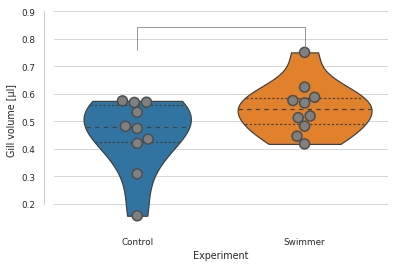

In [131]:
# Boxplot of the gills volume for each animal (in ul)
bars = seaborn.violinplot(data=Data, x='Experiment', y='VolumeGills_ul', cut=0, inner='quartiles')
seaborn.swarmplot(data=Data, x='Experiment', y='VolumeGills_ul', s=10, linewidth=1.5,
                  color='gray')
label = False
if label:
    shift = 0.05
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.VolumeGills_ul[c]),
                               horizontalalignment='left', verticalalignment='bottom')
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.VolumeGills_ul[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.ylabel(u'Gill volume [\u03bcl]')  # https://stackoverflow.com/a/2140991/323100
plt.ylim(ymax=Data.VolumeGills_ul.max() * 1.2)
# statistical annotation, see bottom of https://github.com/jbmouret/matplotlib_for_papers
plt.gca().annotate('',
                   xy=(0, Data.VolumeGills_ul.max()),
                   xycoords='data',
                   xytext=(1, Data.VolumeGills_ul.max()),
                   textcoords='data',
                   arrowprops=dict(arrowstyle="-", ec='gray', connectionstyle="bar, fraction=0.15"))
seaborn.despine(offset=10, trim=True, bottom=True)
if label:
    plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_ul_from%04dslices.png' % NumberOfImagesToShow), bbox_inches = 'tight')
else:
    plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_ul_from%04dslices_nolabel.png' % NumberOfImagesToShow), bbox_inches = 'tight')
plt.show()

In [132]:
# Data as prose
for experiment in Data.Experiment.unique():
    print('The %s fishes have a mean gill volume '
          'of %0.3f ul' % (experiment,
                           Data[Data.Experiment == experiment].VolumeGills_ul.mean()))

The Control fishes have a mean gill volume of 0.453 ul
The Swimmer fishes have a mean gill volume of 0.549 ul


In [133]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(Data.VolumeGillsNormalized)
# nicht signifikant von Normalverteilung unterschiedlich

(0.8930022716522217, 0.03054792247712612)

In [134]:
# Levene -> Varianztest
scipy.stats.levene(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                   Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized)
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

LeveneResult(statistic=0.6463146381699691, pvalue=0.4319231609045947)

In [135]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                     Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized)
# knapp nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

Ks_2sampResult(statistic=0.4, pvalue=0.3128526760169558)

In [136]:
# Are the means different?
t_statistic, p_value = scipy.stats.ttest_ind(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                                             Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized,
                                             equal_var=True)
print("The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
print('F value of %0.4s and a p value of %.2g.' % (t_statistic, p_value / 2))

The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an
F value of -1.6 and a p value of 0.059.


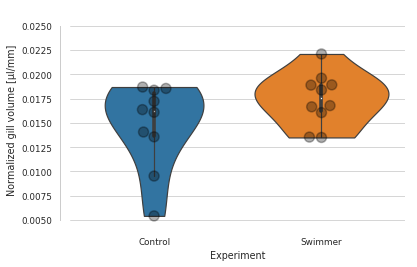

In [137]:
# Boxplot of the NORMALIZED gill volumes
seaborn.violinplot(data=Data, x='Experiment', y='VolumeGillsNormalized', cut=0)
seaborn.swarmplot(data=Data, x='Experiment', y='VolumeGillsNormalized', s=10, linewidth=1.5,
                  color='k', alpha=0.309)
label = False
if label:
    shift = 0.05
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.VolumeGillsNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.VolumeGillsNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')
# plt.title('Normalized gill volume (normalized to fish length)')
plt.ylim(ymax=Data.VolumeGillsNormalized.max() * 1.2)
plt.ylabel(u'Normalized gill volume [\u03bcl/mm]')  # https://stackoverflow.com/a/2140991/323100
seaborn.despine(offset=10, trim=True, bottom=True)
if label:
    plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_Normalized_ul_from%04dslices.png' % NumberOfImagesToShow), bbox_inches = 'tight')
else:
    plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_Normalized_ul_from%04slies_nolabels.png' % NumberOfImagesToShow), bbox_inches = 'tight')
plt.show()

In [138]:
# Are there differences between control and swimmers?
for training in Morphology.Training.unique():
    print(80*'-')
    t_statistic, p_value = scipy.stats.ttest_ind(Respirometry[(Respirometry.Training == training) &
                                                              (Respirometry.Experiment == 'Control')].o2.dropna(),
                                                 Respirometry[(Respirometry.Training == training) &
                                                              (Respirometry.Experiment == 'Swimmer')].o2.dropna(),
                                                 equal_var=True)
    print("At %s, the 'o2' for 'Control' and 'Swimmer' have a" % training)
    # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
    print('F value of %0.4s and a p value of %.2g (%s).' % (t_statistic, p_value / 2, significance(p_value/2)))

--------------------------------------------------------------------------------
At Before, the 'o2' for 'Control' and 'Swimmer' have a
F value of 0.19 and a p value of 0.42 (not significant (p=0.424)).
--------------------------------------------------------------------------------
At After, the 'o2' for 'Control' and 'Swimmer' have a
F value of -2.6 and a p value of 0.0081 (** (p=0.00811)).


In [139]:
# Are the 02 consumptions between trainings different?
for experiment in Respirometry.Experiment.unique():
    for trainings in itertools.combinations(Respirometry.Training.unique(), 2):
        print(80*'-')
        t_statistic, p_value = scipy.stats.ttest_ind(Respirometry[(Respirometry.Training == trainings[0]) &
                                                                  (Respirometry.Experiment == experiment)].o2.dropna(),
                                                     Respirometry[(Respirometry.Training == trainings[1]) &
                                                                  (Respirometry.Experiment == experiment)].o2.dropna(),
                                                     equal_var=True)
        print("For the %s group, the '02' between '%s' and '%s' has an" % (experiment,
                                                                           trainings[0],
                                                                           trainings[1]))
        # Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
        print('F value of %0.4s and a p value of %.2g. (%s)' % (t_statistic, p_value / 2, significance(p_value/2)))

--------------------------------------------------------------------------------
For the Control group, the '02' between 'Before' and 'After' has an
F value of 1.70 and a p value of 0.053. (not significant (p=0.0526))
--------------------------------------------------------------------------------
For the Swimmer group, the '02' between 'Before' and 'After' has an
F value of -0.2 and a p value of 0.42. (not significant (p=0.416))


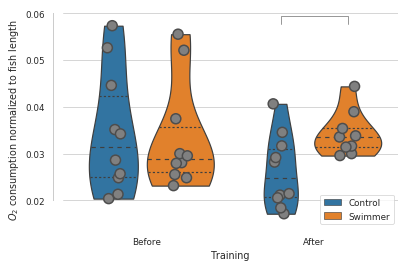

In [140]:
# Display respirometry data
seaborn.violinplot(data=Respirometry, hue='Experiment', y='o2', x='Training', cut=0, inner='quartiles')
# seaborn.boxplot(data=Respirometry, hue='Experiment', y='o2', x='Training', showfliers=False, notch=True)
seaborn.stripplot(data=Respirometry, hue='Experiment', y='o2', x='Training',
                  dodge=True, s=10, linewidth=1.5,
                  palette=['gray', 'gray'])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2], loc='lower right')
plt.ylabel('$O_{2}$ consumption normalized to fish length')

# statistical annotation, see bottom of https://github.com/jbmouret/matplotlib_for_papers
plt.gca().annotate('',
                   xy=(1-0.2, Respirometry['o2'].max()),
                   xycoords='data',
                   xytext=(1+0.2, Respirometry['o2'].max()),
                   textcoords='data',
                   arrowprops=dict(arrowstyle="-", ec='gray', connectionstyle="bar, angle=180, fraction=0.15"))

seaborn.despine(offset=10, trim=True, bottom=True)
plt.savefig(os.path.join(OutPutDir, 'O2_normalized.png'), bbox_inches = 'tight')
plt.show()

In [141]:
for experiment in Data.Experiment.unique():
    print('The normalized O2 consumption for '
          'the %s group at start was '
          '%0.4f with a STD of %0.4f.' % (experiment,
                                          Data[Data.Experiment == experiment]['O2 consumption start normalized'].mean(),
                                          Data[Data.Experiment == experiment]['O2 consumption start normalized'].std()))

The normalized O2 consumption for the Control group at start was 0.0345 with a STD of 0.0130.
The normalized O2 consumption for the Swimmer group at start was 0.0334 with a STD of 0.0114.


In [142]:
print('This is an increase (control to swimmer) '
      'of %0.2f %%' % percentage(Data[Data.Experiment == 'Control']['O2 consumption start normalized'].mean(),
                                 Data[Data.Experiment == 'Swimmer']['O2 consumption start normalized'].mean()))

This is an increase (control to swimmer) of -3.08 %


In [143]:
for experiment in Data.Experiment.unique():
    print('The normalized O2 consumption for '
          'the %s group at end was '
          '%0.4f with a STD of %0.4f.' % (experiment,
                                          Data[Data.Experiment == experiment]['O2 consumption end normalized'].mean(),
                                          Data[Data.Experiment == experiment]['O2 consumption end normalized'].std()))          

The normalized O2 consumption for the Control group at end was 0.0263 with a STD of 0.0078.
The normalized O2 consumption for the Swimmer group at end was 0.0343 with a STD of 0.0048.


In [144]:
print('This is an increase (control to swimmer) '
      'of %0.2f %%' % percentage(Data[Data.Experiment == 'Swimmer']['O2 consumption end normalized'].mean(),
                                 Data[Data.Experiment == 'Control']['O2 consumption end normalized'].mean()))

This is an increase (control to swimmer) of -23.31 %


In [145]:
for experiment in Data.Experiment.unique():
    print('Increase of %s (start to end) '
          'is %0.2f %%' % (experiment,
                           percentage(Data[Data.Experiment == experiment]['O2 consumption start normalized'].mean(),
                                      Data[Data.Experiment == experiment]['O2 consumption end normalized'].mean())))

Increase of Control (start to end) is -23.72 %
Increase of Swimmer (start to end) is 2.63 %


----
We are done!

In [146]:
# Save data at the end
Data.to_csv('Data_%s.csv' % get_git_hash())
Data.to_csv(os.path.join(OutPutDir, 'Data_%s.csv' % get_git_hash()))
# Speed.to_csv('Speed_%s.csv' % get_git_hash())
Speed.to_csv(os.path.join(OutPutDir, 'Speed_%s.csv' % get_git_hash()))
# Morphology.to_csv('Morphology_%s.csv' % get_git_hash())
Morphology.to_csv(os.path.join(OutPutDir, 'Morphology_%s.csv' % get_git_hash()))
# Filaments.to_csv('Filaments_%s.csv' % get_git_hash())
Filaments.to_csv(os.path.join(OutPutDir, 'Filaments_%s.csv' % get_git_hash()))
# Respirometry.to_csv('Respirometry_%s.csv' % get_git_hash())
Respirometry.to_csv(os.path.join(OutPutDir, 'Respirometry_%s.csv' % get_git_hash()))

In [147]:
print('All data has been saved to %s' % os.path.join(OutPutDir))

All data has been saved to /home/habi/P/Documents/Zebrafish-Gills/Output/7f5b1e4


In [148]:
print('Done!')

Done!
